### Libraries

In [11]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import pandas as pd
import plotly_express as px
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, TimeDistributed, Input
from tensorflow.keras.models import load_model

### MLFlow settings

Setup MLflow:

In [ ]:
import os
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_CNN_Testing-CNN_LSTM_1_seasonality-Loop_1"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


### My own functions

In [13]:
from functions_laura.Data_processing import resample, resample_one_station, one_station_resample_with_seasonality_no_uuid
from functions_laura.Data_cleaning import data_cleaning_datetime

from functions_nico import nico_fuelprophet

# Deep Neural Networks for Time Series Analysis

We can use Deep Neural Networks to analyze time series. There are several options how to do this. 
We can use 
* convolutional neural networks (CNN)
* long-term short memory (LSTM)

or even hybrid models that combine CNN and LSTM layers.

Additionally to the timeseries data that we put in to analyze, we can add features to improve model performance.

### potential features
In the case of gas stations, we can think of the following features that potentially have an effect:
* Day of the week
* Station Type (LKW, Automat, Autobahn, rest stop)
* Oil price
* Exchange Rate
* Location
* Density
* Brand
* Dominant Gas station
* Opening times
* Mean price in radius or city

First, we load the data and clean it a little bit:

# Loading train/test data

In [14]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

# Rename date to datetime

In [15]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

### Data processing (without feature engineering)

We split the data into train, test and validation:

[-------- Train --------][--- Validation ---][--- Test ---]


It is important to process the data correctly.


1) choose the data of one gas station (using the uuid)
2) define the training data and the test data to avoid data leakage
3) define your sliding window 
4) Create sequences of your train data
5) Create sequences of your test data defining input and output 


### The sliding window to prepare sequential data
so it can fit into my model. We are using a sliding window of 288 (1 day). After every 288 e5 prices, we look at the price that comes after it. 
$X$ is an array consisting of all the sequences, so it has 288 columns.
$y$ is a 1D array of all these values that come after the 288 (= the next step)

$X$ and $y$ have 288 less rows than the original df, because:

| i    | Input `X[i]` (rows used) | Target `y[i]` |
| ---- | ------------------------ | ------------- |
| 0    | rows 0 to 287            | row 288, E5   |
| 1    | rows 1 to 288            | row 289, E5   |
| 2    | rows 2 to 289            | row 290, E5   |
| ...  | ...                      | ...           |
| 9711 | rows 9711 to 9998        | row 9999, E5  |

# Functions script

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Input
import mlflow.keras
import keras
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


###################################################################################################
def prepare_forecast_data(df_test, scaler,
                            forecast_output_start,
                            days_output,
                            fuel='e5',
                            window_size=288):
    """
    Prepare scaled forecast input data for multi-step forecasting using one column (e.g., 'e5').

    Parameters:
    - df: pandas DataFrame with datetime index
    - scaler: fitted MinMaxScaler
    - forecast_input_start: datetime, start of input window
    - forecast_output_start: datetime, start of output window
    - days_input: number of days for input
    - days_output: number of days for prediction
    - fuel: string, name of the column to use (default: 'e5')
    - window_size: number of steps per day (default: 288 for 5-min data)

    Returns:
    - X_forecast: np.array of shape (steps_to_predict, window_size, 1)
    ###- forecast_timestamps: list of timestamps corresponding to each prediction###
    """
    df = df_test.copy()
    
    
    df["time_index"] = np.arange(len(df))

    input_mask = (df.index < forecast_output_start)
    output_mask = (df.index >= forecast_output_start) & (
        df.index < forecast_output_start + pd.Timedelta(days=days_output)
    )

    input_rows = df[input_mask]["time_index"].values
    output_rows = df[output_mask]["time_index"].values

    # expected_input_rows = days_input * window_size
    # expected_output_rows = days_output * window_size

    # if len(input_rows) != expected_input_rows:
    #     raise ValueError(f"Expected {expected_input_rows} input rows, got {len(input_rows)}")
    # if len(output_rows) != expected_output_rows:
    #     raise ValueError(f"Expected {expected_output_rows} output rows, got {len(output_rows)}")

    start_idx = input_rows[0]
    end_idx = output_rows[-1] + 1

    values = df[['seasonal_component', fuel]].values
    scaled_values = scaler.transform(values)
    forecast_slice = scaled_values[start_idx:end_idx]

    total_target_steps = len(output_rows)
    X_forecast = []

    for i in range(total_target_steps):
        window = forecast_slice[i:i + window_size]
        X_forecast.append(window)

    X_forecast = np.array(X_forecast)  # shape: (288, 288, 1)
    #forecast_timestamps = df.iloc[output_rows].index.tolist()

    y_test = df.loc[
    (df.index >= forecast_output_start) &
    (df.index < forecast_output_start + pd.Timedelta(days=days_output)),
    fuel  # or whatever fuel column you're forecasting
    ].values.reshape(-1, 1)

    return X_forecast, y_test
####################################################################################################
def create_sequences(
        data, 
        window_size, 
        target_col_index):
    """Create sequences for time series prediction.
    
    Args:
        data: Scaled input data with shape (samples, features)
        window_size: Number of time steps to look back
        target_col_index: Index of the target column to predict
        
    Returns:
        X: Input sequences with shape (samples, window_size, features)
        y: Target values with shape (samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        # Get sequence of all features
        sequence = data[i:(i + window_size)]
        X.append(sequence)
        # Get next value of target feature
        target = data[i + window_size, target_col_index]
        y.append(target)
    return np.array(X), np.array(y)
##################################################################
def preprocess(
        df_train, df_test,
        start_forecast=None,
        fuel='e5',
        output_days=1,
        verbose=True):
    
    # Filter and resample
    df_train = one_station_resample_with_seasonality_no_uuid(df_train)
    df_test = one_station_resample_with_seasonality_no_uuid(df_test)

    # Split data
    # Find the middle point of df_test
    middle_idx = len(df_train) // 2
    
    test_df = df_test
    train_df = df_train[:middle_idx].copy()  # First half
    val_df = df_train[middle_idx:].copy()  # Second half

    # set datetime index
    train_df.set_index('datetime', inplace=True)
    val_df.set_index('datetime', inplace=True)
    test_df.set_index('datetime', inplace=True)

    # Calculate start_forecast automatically (output_days days before end of test set)
    start_forecast = test_df.index.max() - pd.Timedelta(days=output_days)

    # Scaling
    scaler = MinMaxScaler()
    features = ['seasonal_component', fuel]
    scaler.fit(train_df[features])

    scaled_train = scaler.transform(train_df[features])
    scaled_val = scaler.transform(val_df[features])
    #scaled_test = scaler.transform(test_df[[fuel]])  # optional

    # Sequence generation
    window_size = 288
    target_col_index = 1

    X, y = create_sequences(scaled_train, window_size, target_col_index)
    X_val, y_val = create_sequences(scaled_val, window_size, target_col_index)

    # Forecast setup
    start_forecast = pd.to_datetime(start_forecast)
    X_forecast, y_test = prepare_forecast_data(test_df, forecast_output_start=start_forecast,
                                       days_output=output_days, scaler=scaler)


    ### === Verbose plots === ###
    if verbose:
        # Time series overview
        plt.figure(figsize=(10,6))
        plt.plot(train_df.index, train_df[fuel], label='Train', drawstyle='steps-post')
        plt.plot(val_df.index, val_df[fuel], label='Validation', drawstyle='steps-post')
        plt.plot(test_df.index, test_df[fuel], label='Test', drawstyle='steps-post')
        plt.title("Train, Validation, and Test Data")
        plt.xlabel("Date")
        plt.ylabel(f"{fuel} Price")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("Data_overview.png")
        mlflow.log_artifact("Data_overview.png")
        plt.show()

        # KDE for distribution comparison
        kde_train = gaussian_kde(train_df[fuel].dropna())
        kde_val = gaussian_kde(val_df[fuel].dropna())
        kde_test = gaussian_kde(test_df[fuel].dropna())

        x_vals = np.linspace(
            min(train_df[fuel].min(), val_df[fuel].min(), test_df[fuel].min()),
            max(train_df[fuel].max(), val_df[fuel].max(), test_df[fuel].max()), 1000
        )

        plt.figure(figsize=(10,4))
        plt.plot(x_vals, kde_train(x_vals), label='Train', color='blue')
        plt.plot(x_vals, kde_val(x_vals), label='Validation', color='green')
        plt.plot(x_vals, kde_test(x_vals), label='Test', color='orange')
        plt.title(f"KDE of {fuel} in Train, Validation, Test")
        plt.xlabel(f"{fuel} Value")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.savefig("KDE.png")
        mlflow.log_artifact("KDE.png")
        plt.show()

        print(f"Train shape: {X.shape}  | Validation shape: {X_val.shape}")
        print(f"Forecast setup from {test_df.index.min()} to {start_forecast}, to predict {output_days} day(s)")
        print(f"Test set range: {test_df.index.min()} to {test_df.index.max()}")

    return X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df

#########################################################################################

def build_model(model_type, params, input_shape=(288, 2)):
    model = Sequential()
    if model_type == 'cnn_small':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu')) # 1-dimensional deconvolution
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        ########################################################################
    elif model_type == 'cnn_big':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.2))
        ########################################################################
    elif model_type == 'cnn_lstm_1':
        model.add(Input(shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(params['lstm_units'], return_sequences=False))
        ########################################################################
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mse')

    return model

########################################################################

def train_model_with_mlflow(X, y, X_val, y_val, model_type, params, days_output=None, input_shape=(288, 2)):
    # Log parameters manually (optional if autolog is on)
    mlflow.log_param("days_output", days_output)
    mlflow.set_tag("dataset", f'{df_train}_{df_test}')
    mlflow.set_tag("model_type", model_type)
    
    model = build_model(model_type=model_type, params=params, input_shape=input_shape)
    # Train model
    history = model.fit(
        X, y,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    # Log final metrics manually if you want more control
    final_val_loss = history.history['val_loss'][-1]
    mlflow.log_metric("final_val_loss", final_val_loss)
    # Optionally log a plot
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss over Epochs")
    plt.legend()
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")
    model_path = 'model.keras'
    keras.saving.save_model(model, model_path, save_format="keras")
    mlflow.log_artifact(model_path)

    return model, history

########################################################################

# Helper Functions

def inverse_scale(preds, original_data, target_index, scaler):
    """Inverse scale predictions by placing them into a dummy array 
    and applying scaler.inverse_transform."""
    dummy = np.zeros((len(preds), original_data.shape[1]))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# Function that forecasts and prints the forecast
def forecasting(
        X_forecast,
        scaled_train,
        scaler,
        fuel='e5',
        model= None,
    ):
    '''
    _summary_

    Args:
        X_forecast (np.array): Output from processing function
        scaled_train (np.array): Output from processing function
        scaler (fitted MinMax Scaler): Output from processing function
        start_forecast (string): date of forecast start already defied in the processing function
        fuel (str, optional): Fuel type, 'es', 'e10' or 'diesel'. Defaults to 'e5'.
    '''
    
    #make predictions
    y_pred_forecast = model.predict(X_forecast)
    #scale the predictions back to original scale
    y_pred = inverse_scale(y_pred_forecast, scaled_train, target_index=1, scaler=scaler)

    # reattach the datetime to prediction
    n_predictions = len(y_pred)
    last_timestamp = test_df.index.max()
    start_datetime = last_timestamp - pd.Timedelta(days=output_days)
    time_index = pd.date_range(start=start_datetime, periods=n_predictions, freq="5min")

    #combine into a DataFrame
    y_pred_df = pd.DataFrame({
        "datetime": time_index,
        "Predicted E5": y_pred
    })
    #make datetime index
    y_pred_df.set_index('datetime', inplace=True)

    # Save forecast to file
    np.savetxt("forecast.csv", y_pred_df, delimiter=",") 
    mlflow.log_artifact("forecast.csv")

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Forecast MSE:", mae)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    mlflow.log_metric("test_mae", mae)
    mlflow.log_metric("test_mape", mape)
    mlflow.log_metric("test_R2", r2)
    #print y_pred to check if it looks as expected
    print(y_pred_df.head()) 

    # Plot
    # Set parameters
    colors = {
        "background": "#f9fcfc",
        "gridcolor": "#dcdbd9",
        "legendedge": "#dcdbd9",
        "legendface": "white",
        "legendcol": "black",
        "textcolor": "black"
    }
    # Create a figure and axis with custom size
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(test_df[fuel], label=f'True Test {fuel}', drawstyle='steps-post', linewidth=3) # line width
    plt.plot(y_pred_df, drawstyle='steps-post', linewidth=3)
    # Set grid with custom color
    ax.grid(True, color=colors["gridcolor"])
    # Change border (spine) colors
    for spine in ax.spines.values():
        spine.set_edgecolor(colors["gridcolor"])
    # Set title and labels
    ax.set_title("Fuel price prediction of one gas station", fontweight="bold", fontsize=18, color=colors["textcolor"])
    ax.set_xlabel("time", fontweight="bold", fontsize=16, color=colors["textcolor"])
    ax.set_ylabel(f"{fuel} price (€/l)", fontweight="bold", fontsize=16, color=colors["textcolor"])
    # Customize tick labels
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
        label.set_color(colors["textcolor"])
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
        label.set_color(colors["textcolor"])
        label.set_fontweight('normal')
    # Set background color
    ax.set_facecolor(colors["background"])
    fig.patch.set_facecolor(colors["background"])
    # Create legend
    plt.legend(fontsize=16,loc='upper right', 
               edgecolor=params.get("legendedge"), 
               facecolor=params.get("legendface"), 
               labelcolor = params.get("legendcol"),
               framealpha=1)
    plt.savefig("forecast.png")
    mlflow.log_artifact("forecast.png")
    plt.show()




# Start of the analysis

In [17]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}


Processing dataset: df01


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


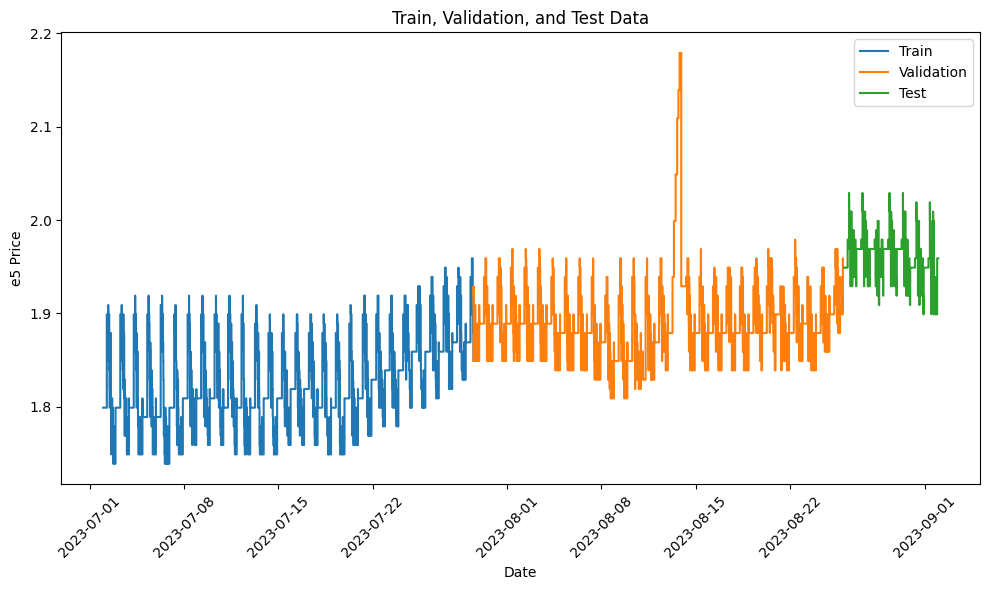

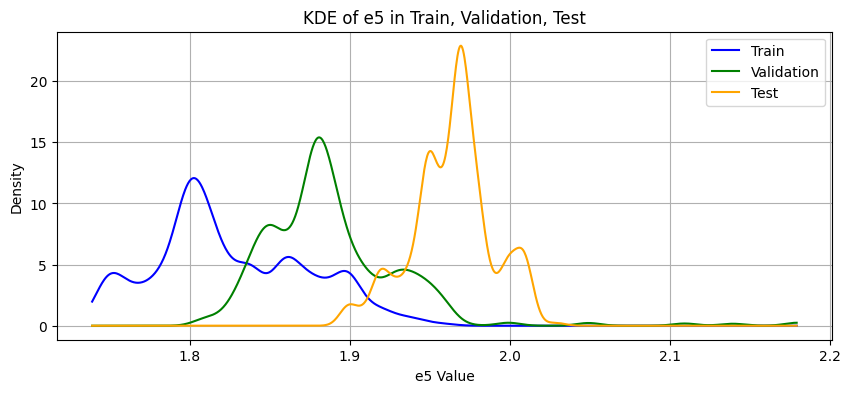

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-08-26 00:05:00 to 2023-09-01 00:00:00, to predict 1 day(s)
Test set range: 2023-08-26 00:05:00 to 2023-09-02 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.0901 - val_loss: 0.2242
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0109 - val_loss: 0.0930
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0076 - val_loss: 0.0543
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - val_loss: 0.1032
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - val_loss: 0.0990
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0054 - val_loss: 0.0991
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0047 - val_loss: 0.1037
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0914
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - val_loss: 0.0951
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038 - val_loss: 0.0823
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0942
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.025666210022237512
                     Predicted E5
datetime                         
2023-09-01 00:00:00      1.955471
2023-09-01 00:05:00      1.959323
2023-09-01 00:10:00      1.959259
2023-09-01 00:15:00      1.963132
2023-09-01 00:20:00      1.960741


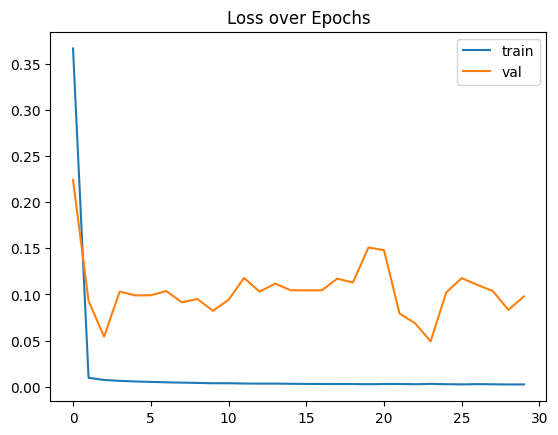

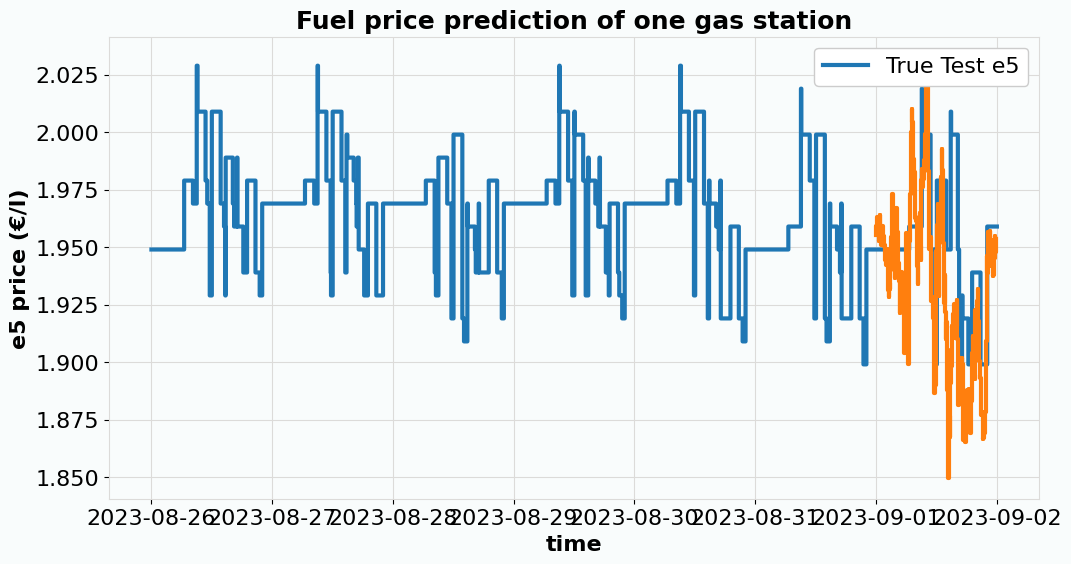

Successfully processed df01

Processing dataset: df02


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


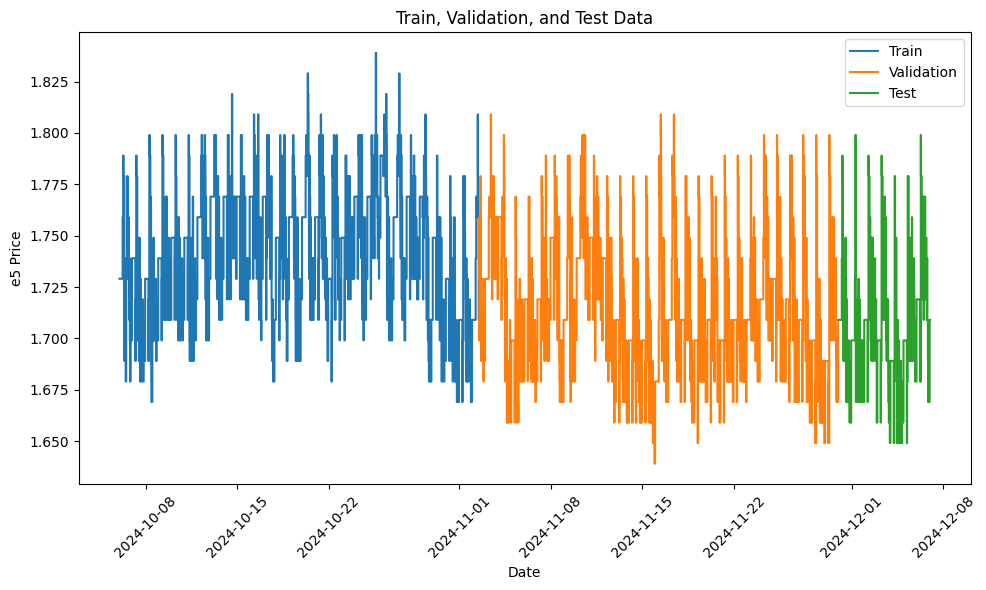

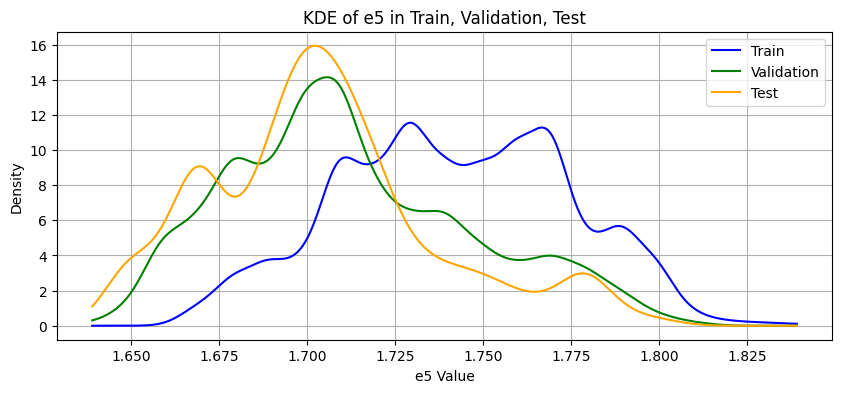

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-11-30 00:05:00 to 2024-12-06 00:00:00, to predict 1 day(s)
Test set range: 2024-11-30 00:05:00 to 2024-12-07 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.6487 - val_loss: 0.0367
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0148 - val_loss: 0.0214
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.03509461675149697
                     Predicted E5
datetime                         
2024-12-06 00:00:00      1.691901
2024-12-06 00:05:00      1.698988
2024-12-06 00:10:00      1.708982
2024-12-06 00:15:00      1.706442
2024-12-06 00:20:00      1.701316


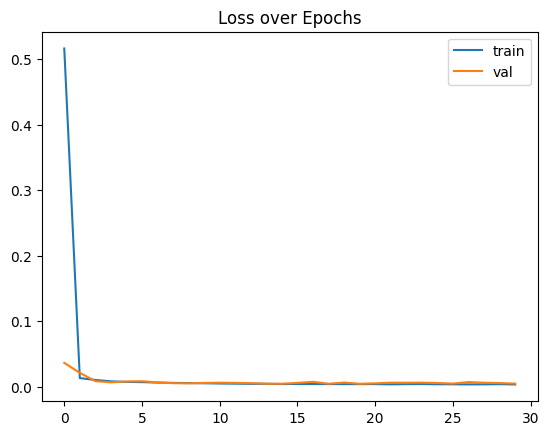

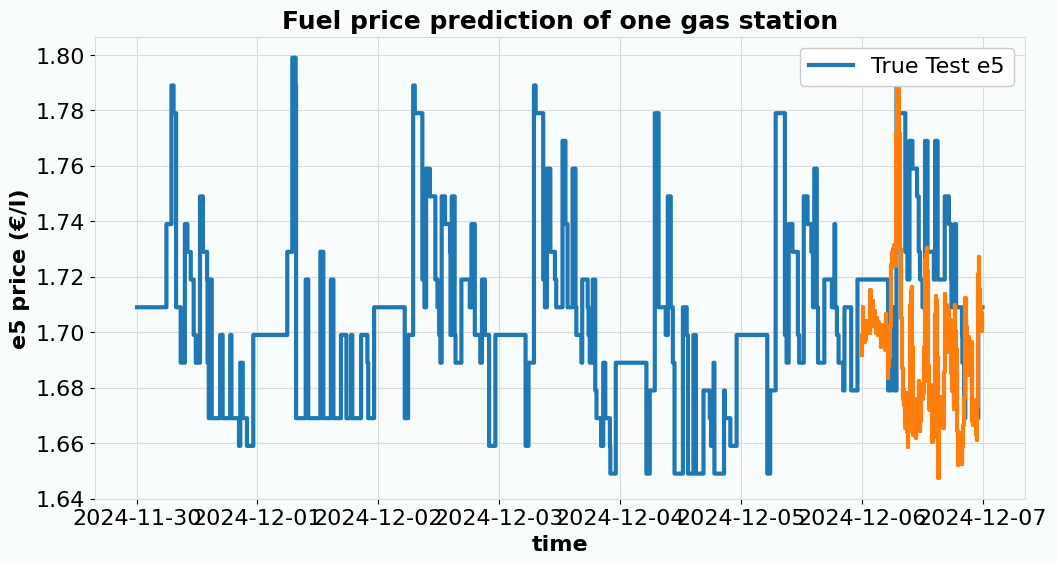

Successfully processed df02

Processing dataset: df03


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


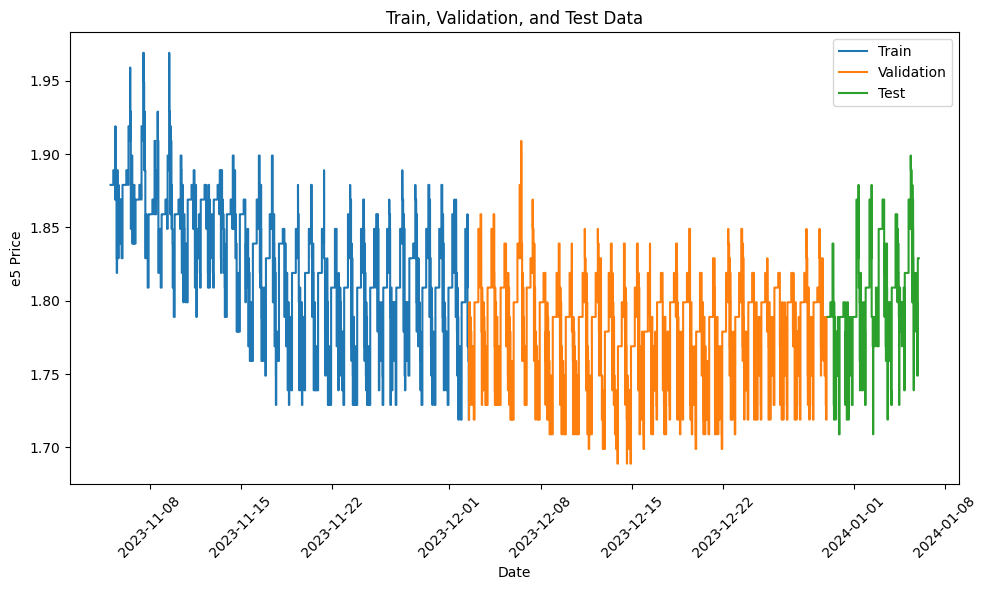

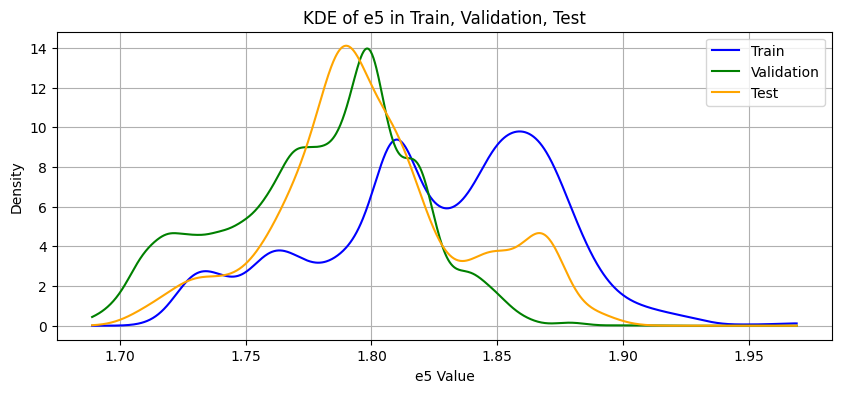

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-30 00:05:00 to 2024-01-05 00:00:00, to predict 1 day(s)
Test set range: 2023-12-30 00:05:00 to 2024-01-06 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.0200 - val_loss: 0.0197
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - loss: 0.0142 - val_loss: 0.0078
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0090 - val_loss: 0.0046
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0075 - val_loss: 0.0043
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.04538198598919218
                     Predicted E5
datetime                         
2024-01-05 00:00:00      1.802070
2024-01-05 00:05:00      1.800791
2024-01-05 00:10:00      1.801217
2024-01-05 00:15:00      1.803114
2024-01-05 00:20:00      1.801367


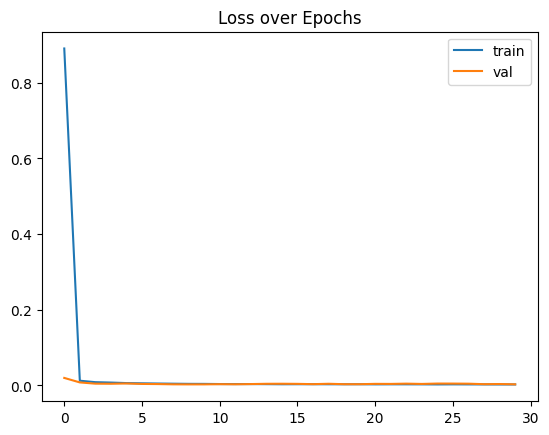

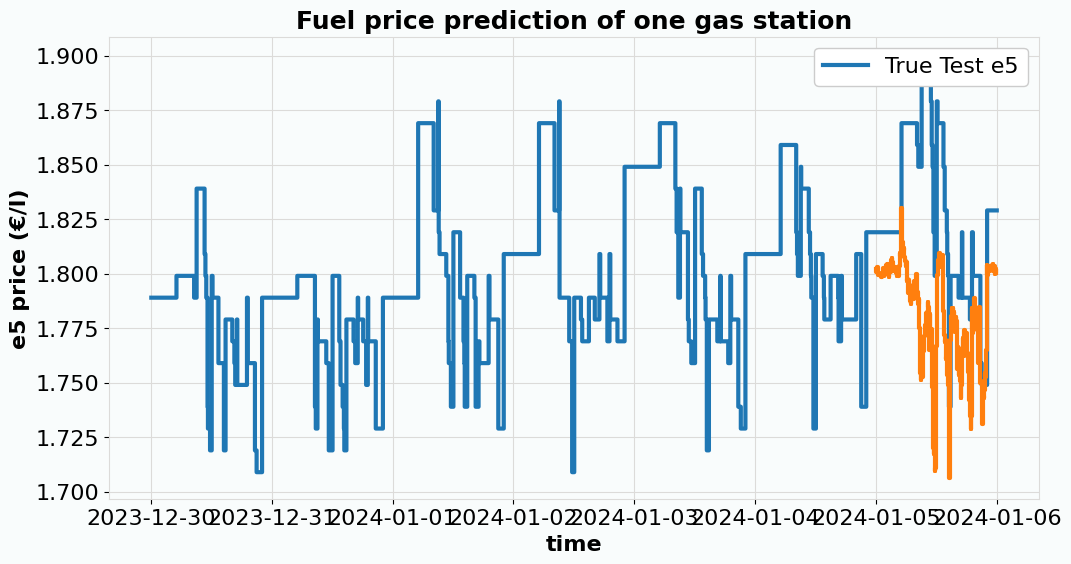

Successfully processed df03

Processing dataset: df04


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


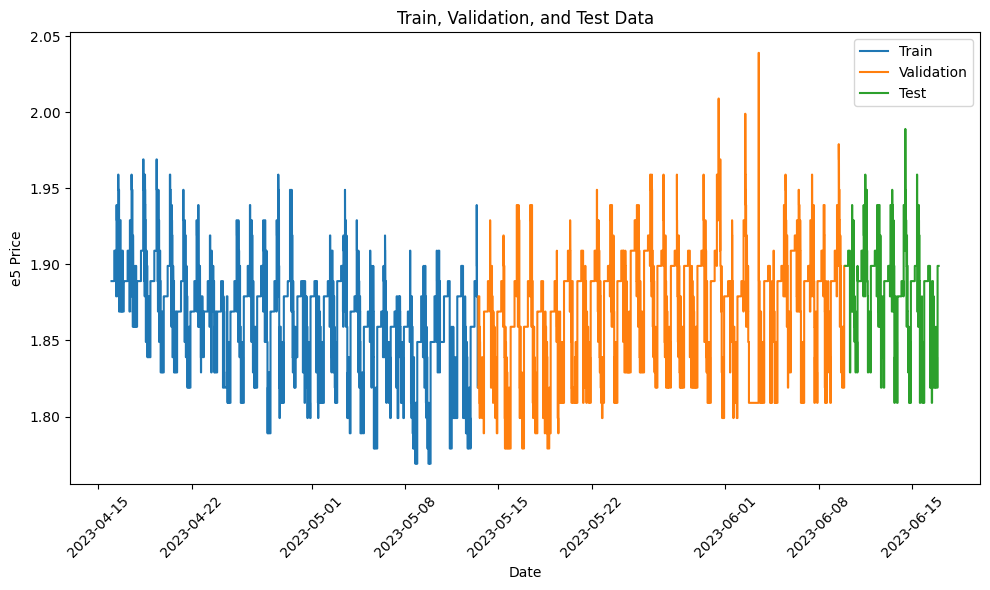

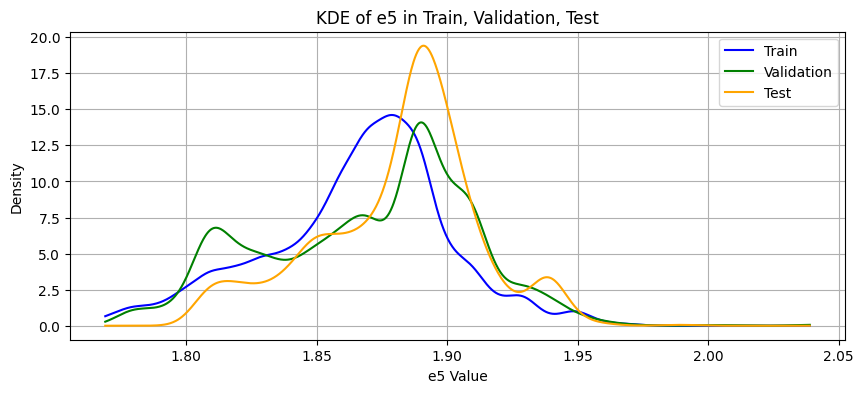

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-06-10 00:05:00 to 2023-06-16 00:00:00, to predict 1 day(s)
Test set range: 2023-06-10 00:05:00 to 2023-06-17 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.2757 - val_loss: 0.1076
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0168 - val_loss: 0.0283
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0090 - val_loss: 0.0057
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.01770541838887666
                     Predicted E5
datetime                         
2023-06-16 00:00:00      1.876551
2023-06-16 00:05:00      1.875690
2023-06-16 00:10:00      1.878009
2023-06-16 00:15:00      1.876460
2023-06-16 00:20:00      1.877631


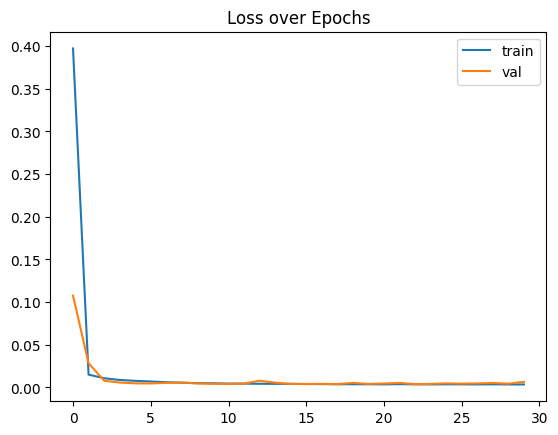

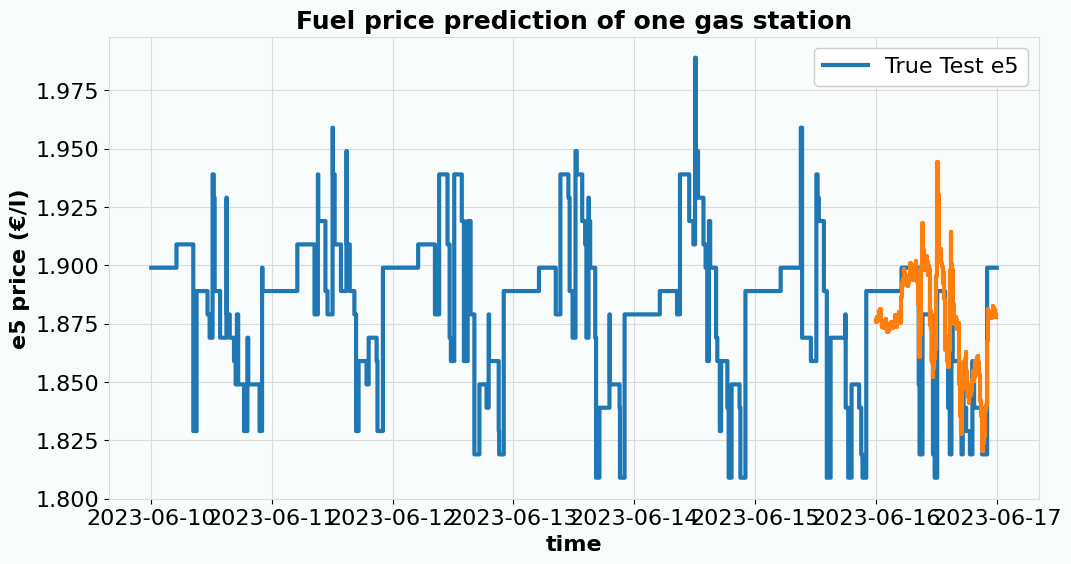

Successfully processed df04

Processing dataset: df05


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


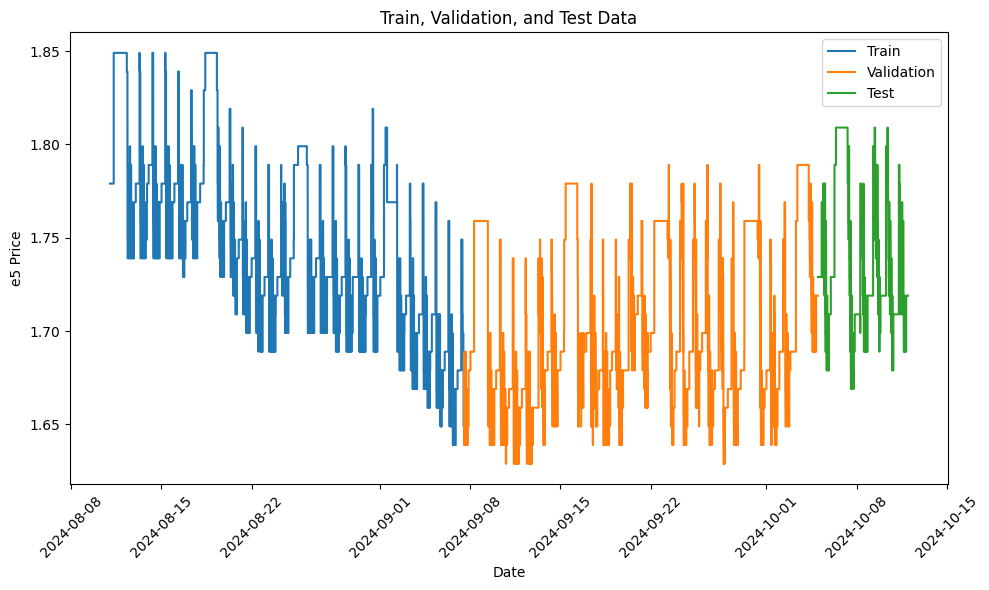

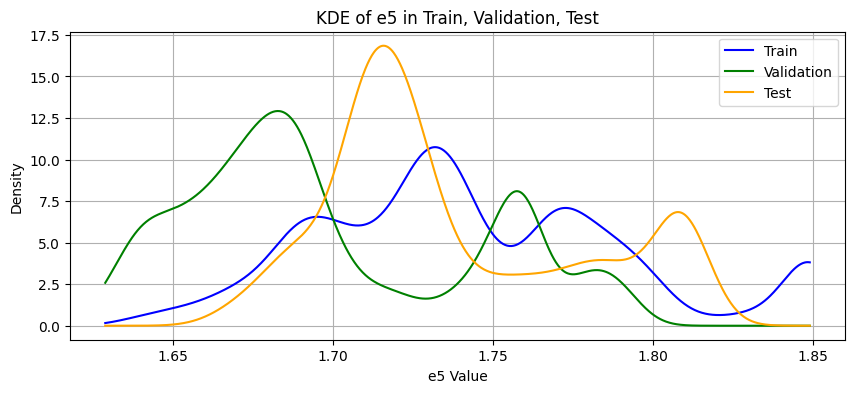

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-10-05 00:05:00 to 2024-10-11 00:00:00, to predict 1 day(s)
Test set range: 2024-10-05 00:05:00 to 2024-10-12 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.3667 - val_loss: 0.0683
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0228 - val_loss: 0.0222
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0100 - val_loss: 0.0061
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0091 - val_loss: 0.0053
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - val_loss: 0.0074
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.057325912867155444
                     Predicted E5
datetime                         
2024-10-11 00:00:00      1.718625
2024-10-11 00:05:00      1.719964
2024-10-11 00:10:00      1.724531
2024-10-11 00:15:00      1.727057
2024-10-11 00:20:00      1.727890


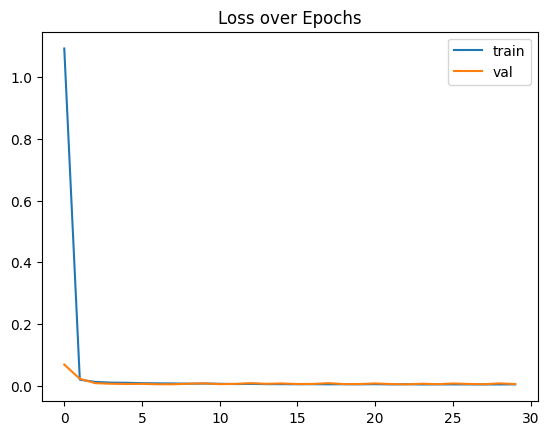

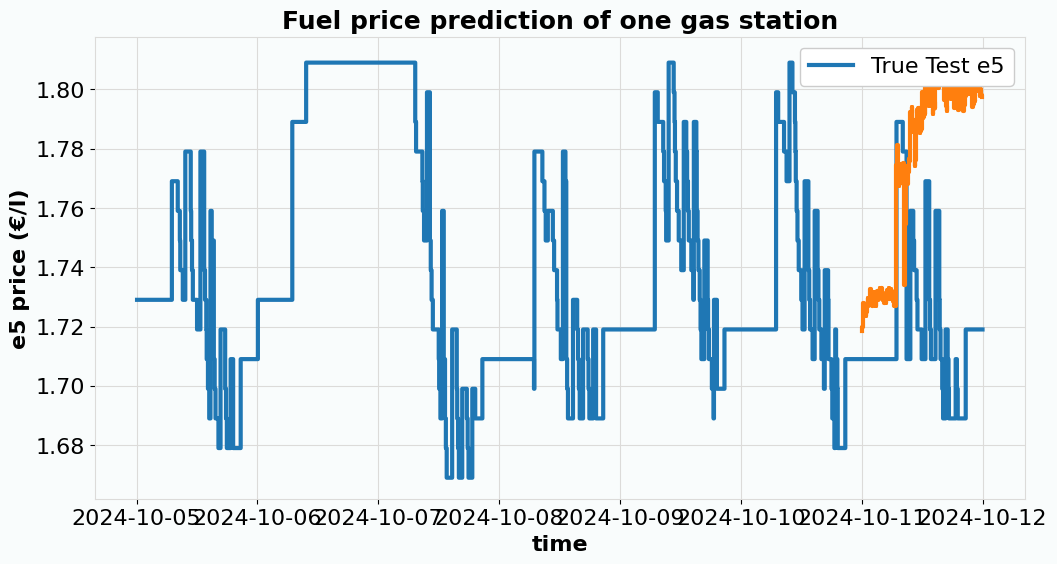

Successfully processed df05

Processing dataset: df06
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

Processing dataset: df07


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


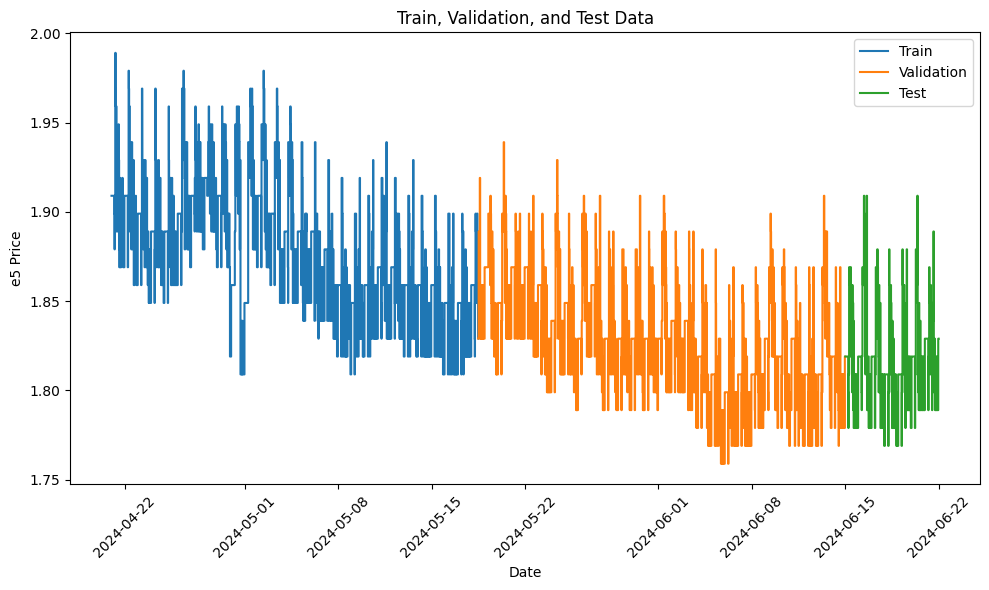

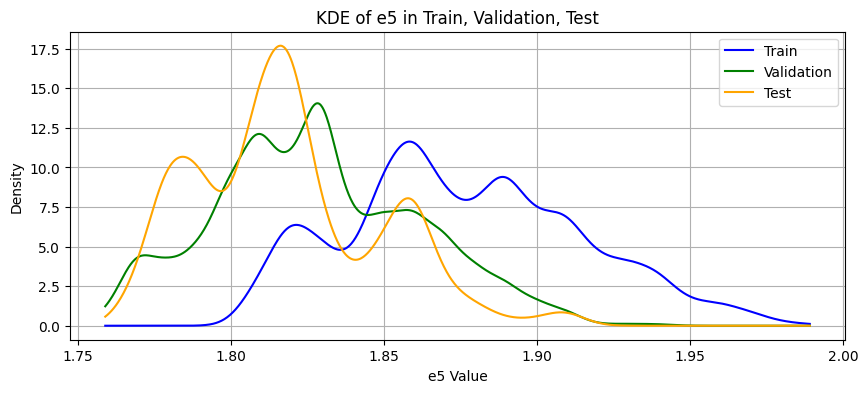

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-06-15 00:05:00 to 2024-06-21 00:00:00, to predict 1 day(s)
Test set range: 2024-06-15 00:05:00 to 2024-06-22 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5024 - val_loss: 0.0322
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0150 - val_loss: 0.0175
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0110 - val_loss: 0.0165
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0098 - val_loss: 0.0458
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - val_loss: 0.0665
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 66s 278ms/step - loss: 0.0083 - val_loss: 0.1151
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0082 - val_loss: 0.0746
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0068 - val_loss: 0.0370
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0066 - val_loss: 0.0286
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0060 - val_loss: 0.0225
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0057 - val_loss: 0.0329
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.11743502960126441
                     Predicted E5
datetime                         
2024-06-21 00:00:00      1.650605
2024-06-21 00:05:00      1.675642
2024-06-21 00:10:00      1.604196
2024-06-21 00:15:00      1.627543
2024-06-21 00:20:00      1.621703


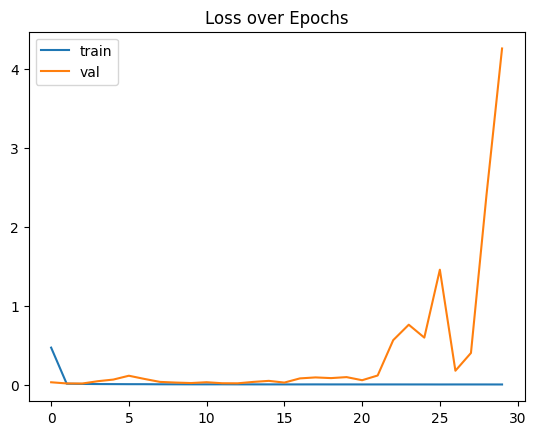

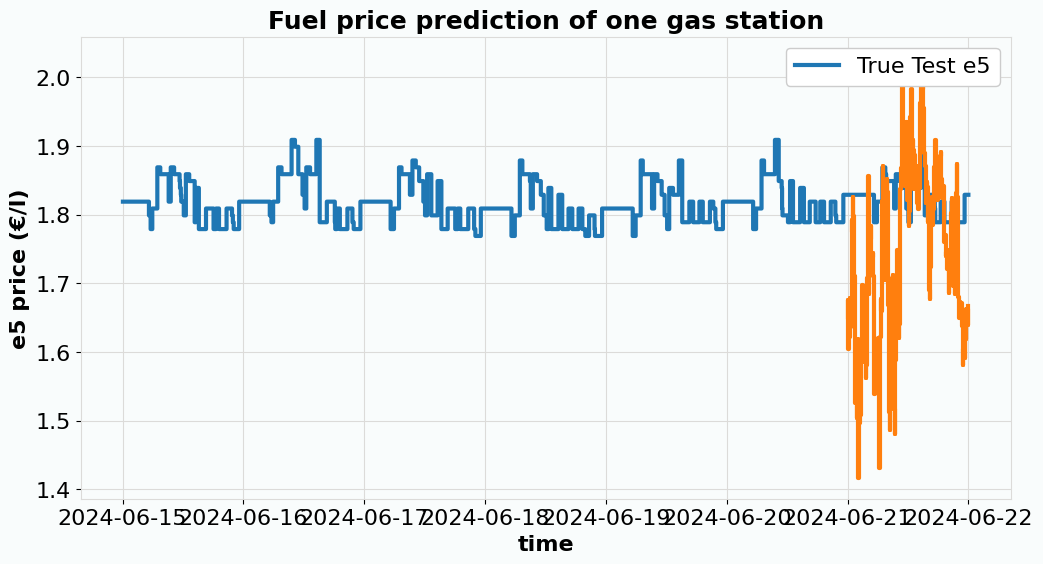

Successfully processed df07

Processing dataset: df08


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


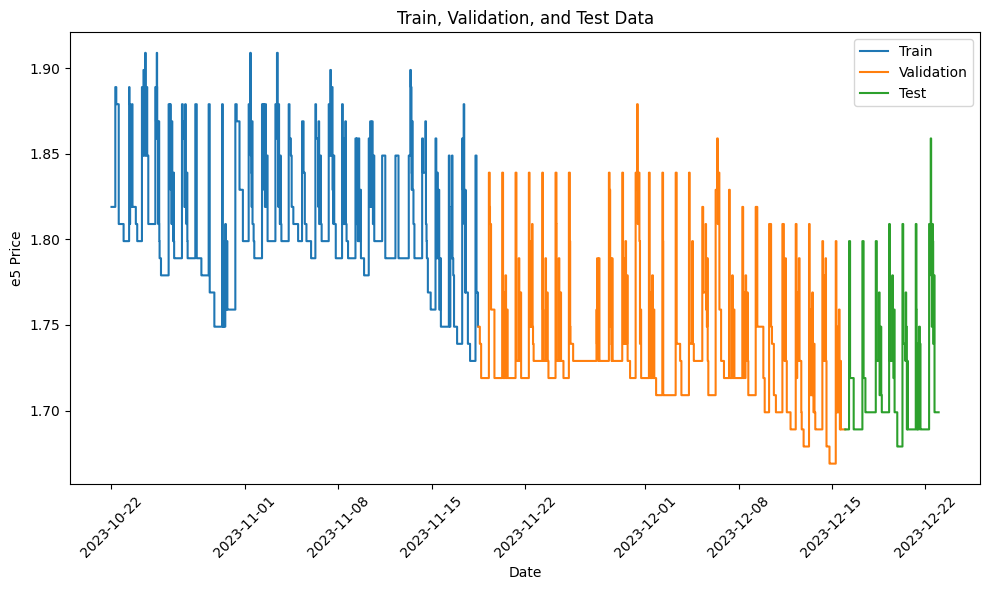

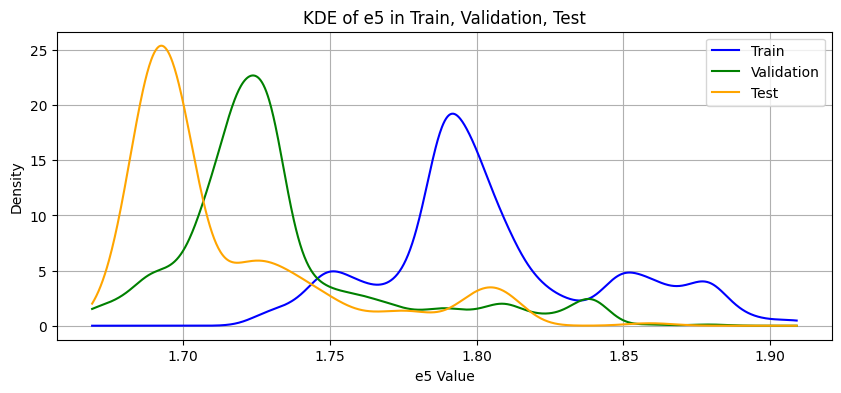

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-16 00:05:00 to 2023-12-22 00:00:00, to predict 1 day(s)
Test set range: 2023-12-16 00:05:00 to 2023-12-23 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.3146 - val_loss: 0.4050
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0133 - val_loss: 26.7054
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0102 - val_loss: 207.7207
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - val_loss: 385.9330
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0069 - val_loss: 430.0910
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0067 - val_loss: 415.4266
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - val_loss: 403.9665
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - val_loss: 447.5098
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0053 - val_loss: 441.7030
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0053 - val_loss: 415.5694
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0047 - val_loss: 405.2242
Epoch 12/30
239/239 ━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 6.250922498040727
                     Predicted E5
datetime                         
2023-12-22 00:00:00     -4.012727
2023-12-22 00:05:00     -3.870186
2023-12-22 00:10:00     -3.879366
2023-12-22 00:15:00     -3.982147
2023-12-22 00:20:00     -4.116529


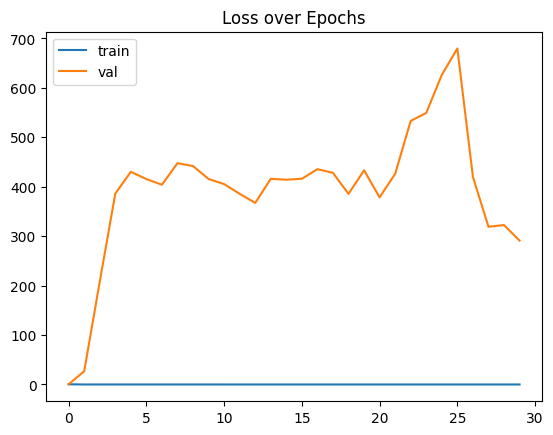

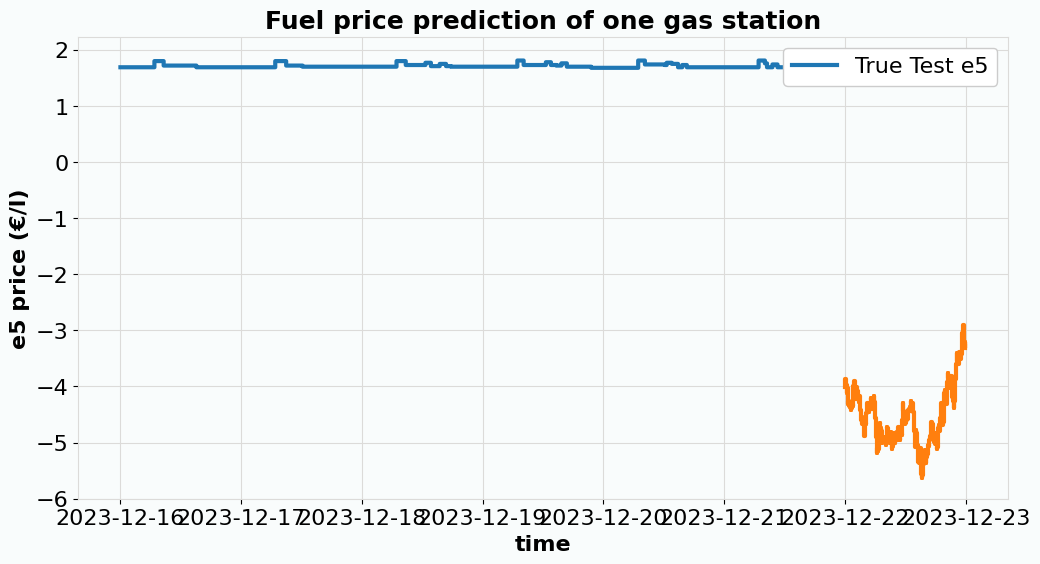

Successfully processed df08

Processing dataset: df09


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


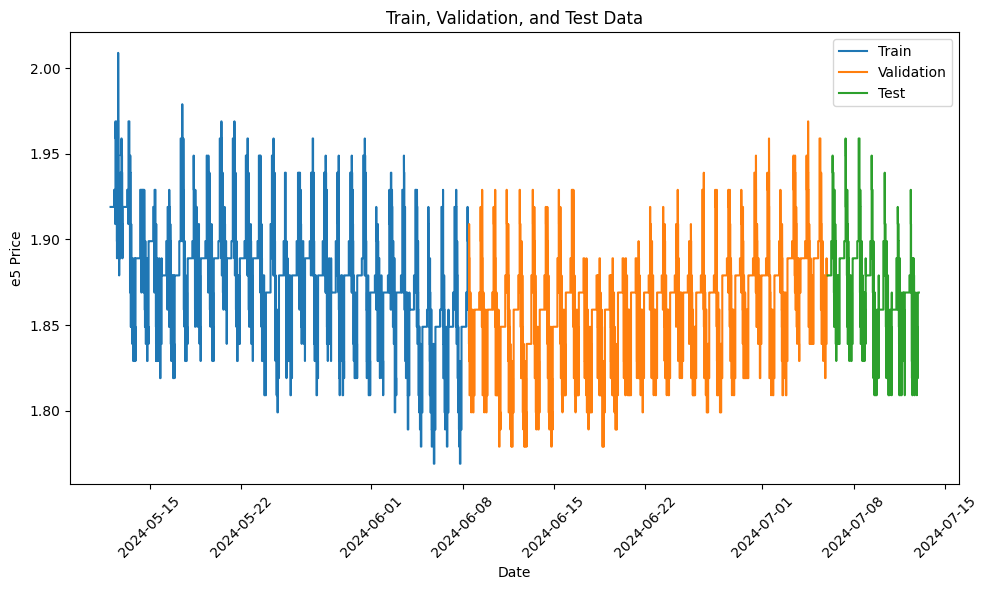

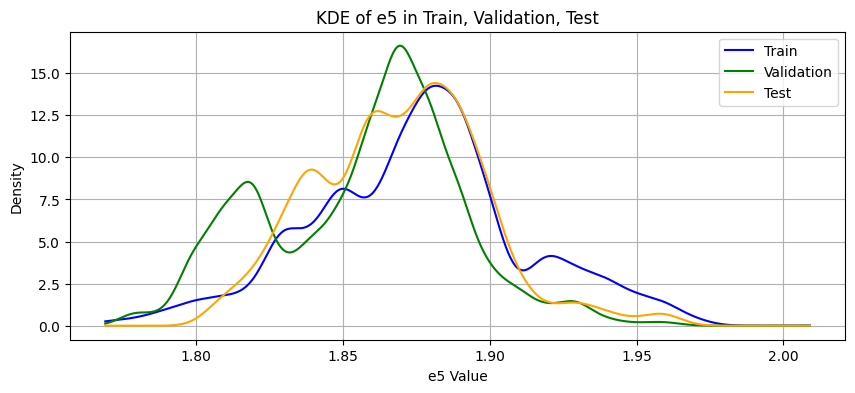

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-07-06 00:05:00 to 2024-07-12 00:00:00, to predict 1 day(s)
Test set range: 2024-07-06 00:05:00 to 2024-07-13 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9876 - val_loss: 0.0332
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.01940937980181637
                     Predicted E5
datetime                         
2024-07-12 00:00:00      1.879632
2024-07-12 00:05:00      1.880109
2024-07-12 00:10:00      1.879619
2024-07-12 00:15:00      1.880083
2024-07-12 00:20:00      1.878664


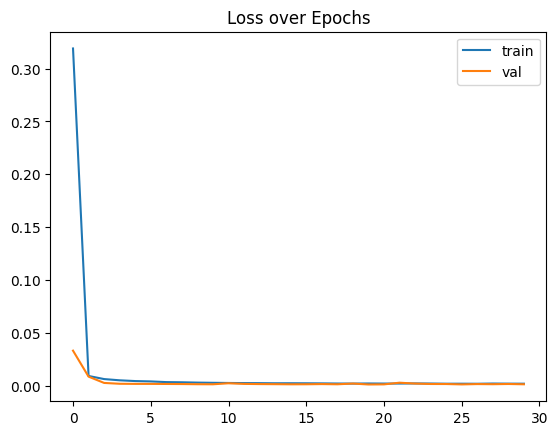

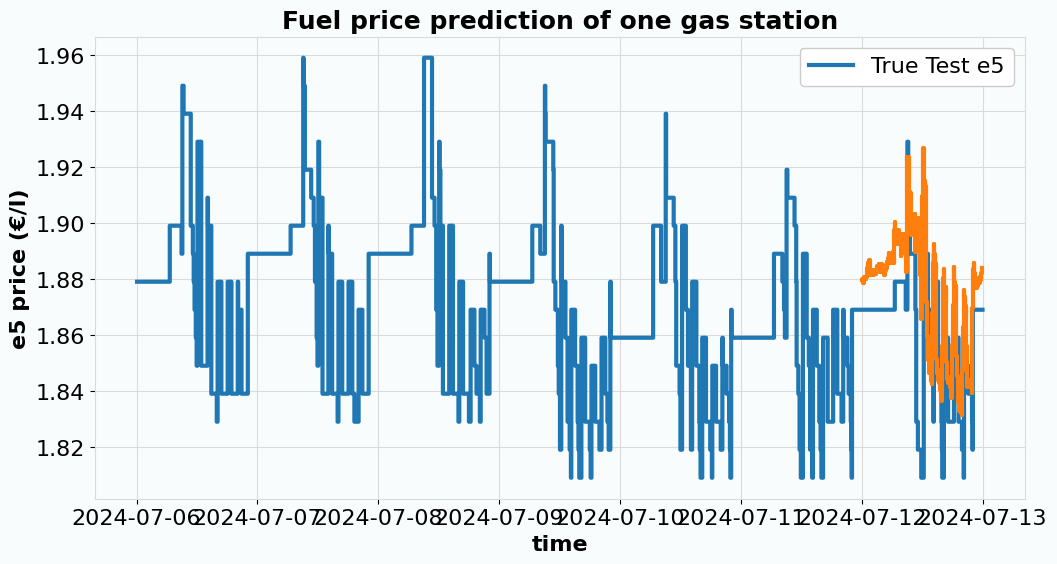

Successfully processed df09

Processing dataset: df10


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


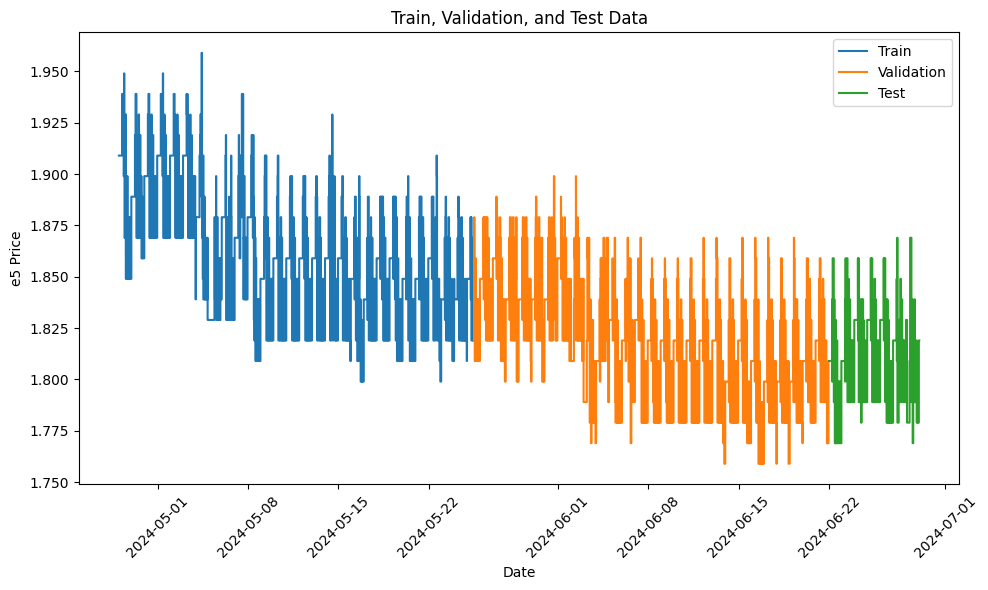

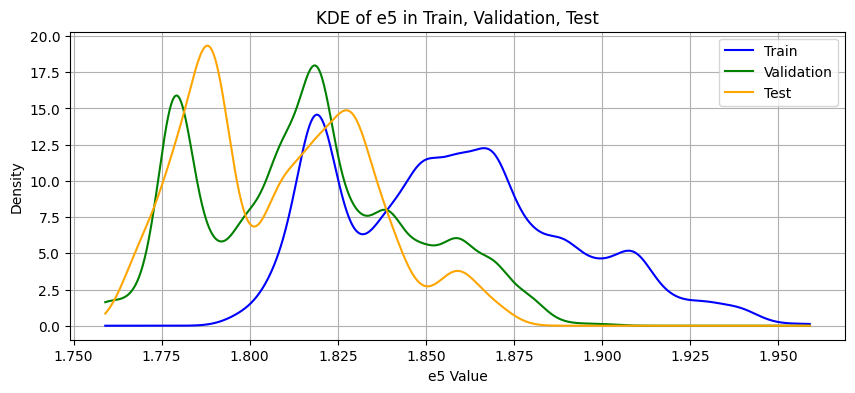

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-06-22 00:05:00 to 2024-06-28 00:00:00, to predict 1 day(s)
Test set range: 2024-06-22 00:05:00 to 2024-06-29 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.2701 - val_loss: 0.0288
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0141 - val_loss: 0.4297
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0105 - val_loss: 5.9542
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - val_loss: 8.8038
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0081 - val_loss: 9.3124
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 8.8323
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - val_loss: 7.3330
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0063 - val_loss: 9.4015
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0059 - val_loss: 7.2720
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0057 - val_loss: 8.9292
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0055 - val_loss: 8.0173
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.44819571966926297
                     Predicted E5
datetime                         
2024-06-28 00:00:00      2.038200
2024-06-28 00:05:00      2.114378
2024-06-28 00:10:00      2.199592
2024-06-28 00:15:00      2.225721
2024-06-28 00:20:00      2.377016


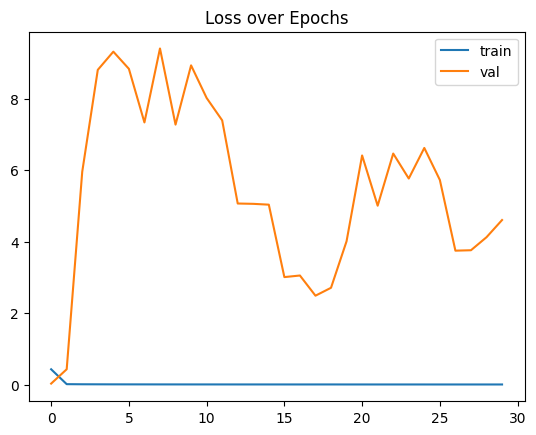

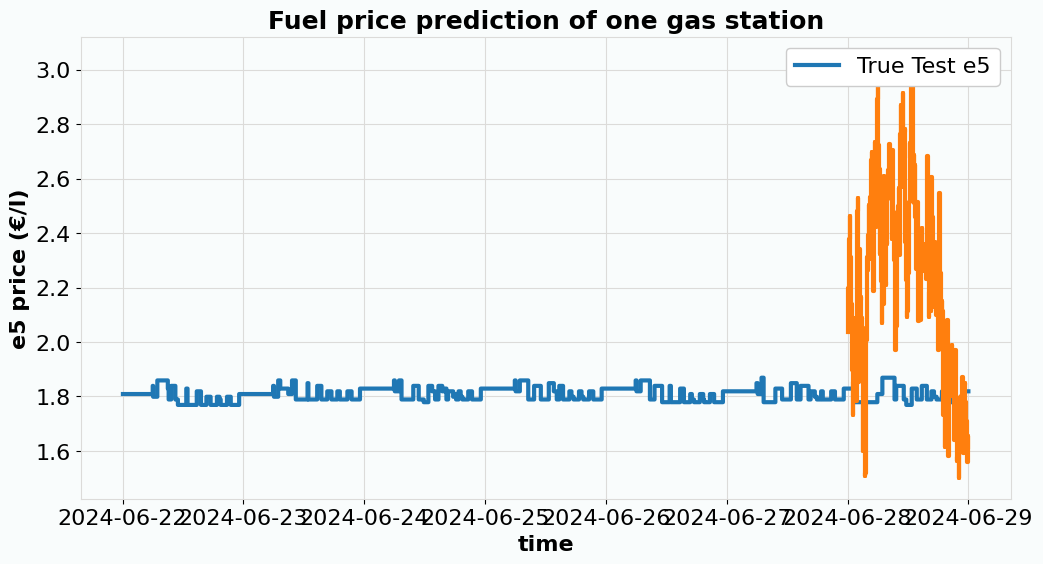

Successfully processed df10

Processing dataset: df11


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


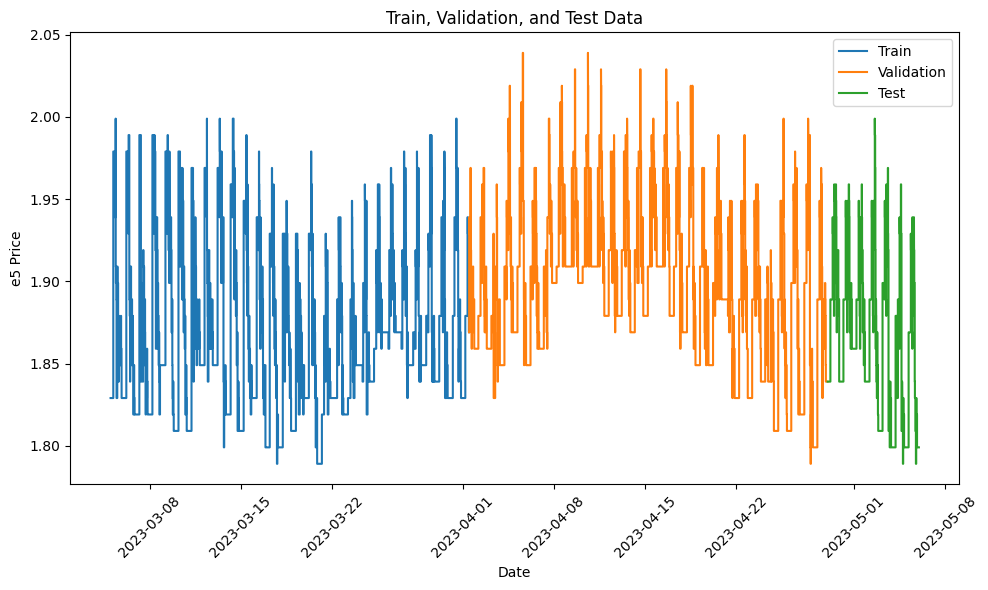

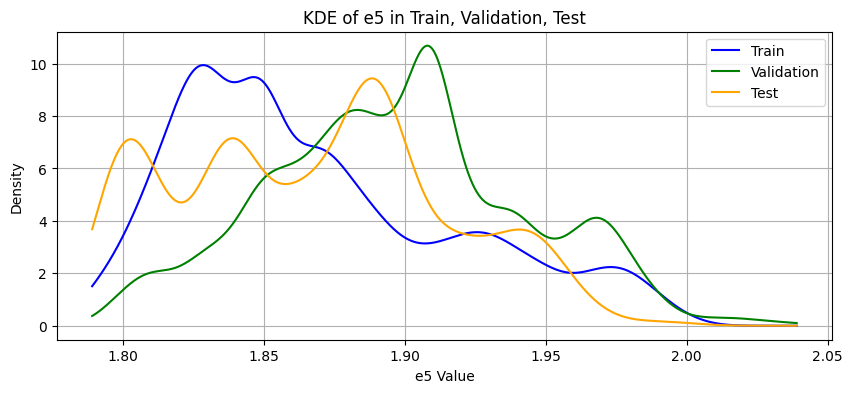

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-04-29 00:05:00 to 2023-05-05 00:00:00, to predict 1 day(s)
Test set range: 2023-04-29 00:05:00 to 2023-05-06 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.0342 - val_loss: 0.2213
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0203 - val_loss: 0.0853
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0107 - val_loss: 0.0074
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0069 - val_loss: 0.0045
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forecast MSE: 0.03915778310659023
                     Predicted E5
datetime                         
2023-05-05 00:00:00      1.838627
2023-05-05 00:05:00      1.837611
2023-05-05 00:10:00      1.841321
2023-05-05 00:15:00      1.839855
2023-05-05 00:20:00      1.836721


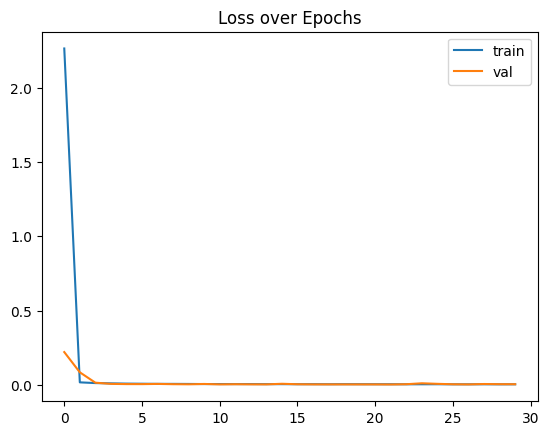

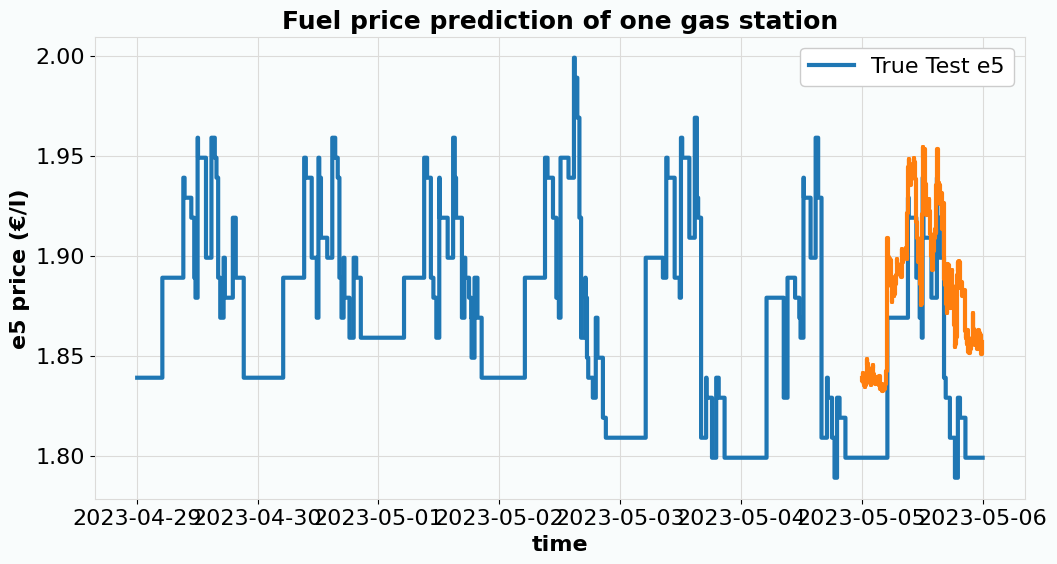

Successfully processed df11

Processing dataset: df12


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


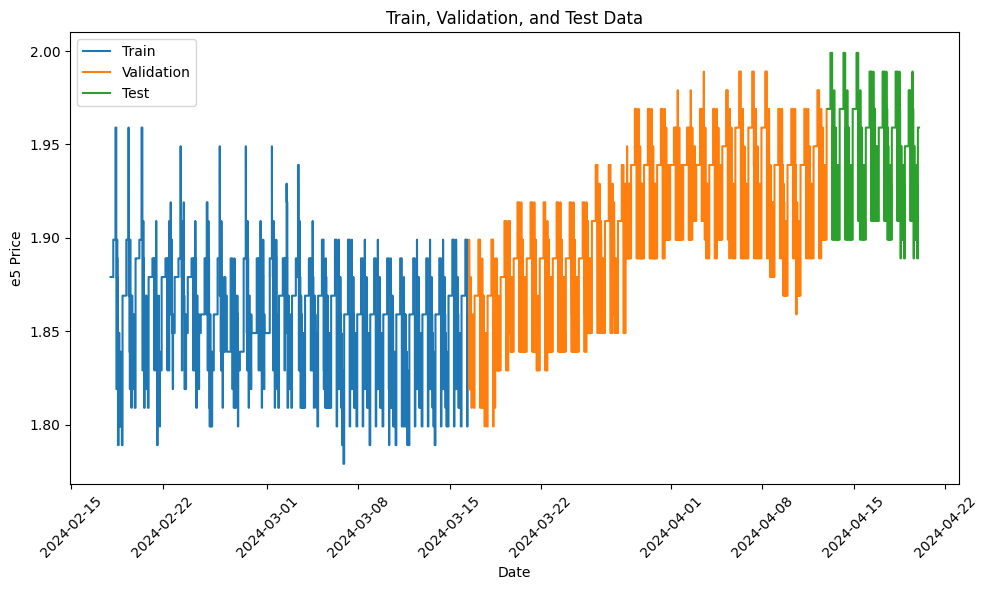

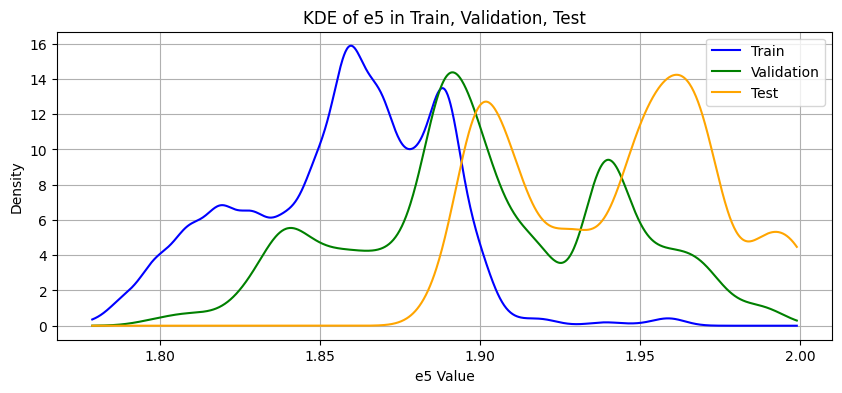

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-04-13 00:05:00 to 2024-04-19 00:00:00, to predict 1 day(s)
Test set range: 2024-04-13 00:05:00 to 2024-04-20 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.4563 - val_loss: 0.1953
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0146 - val_loss: 0.0776
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - val_loss: 0.0119
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - val_loss: 0.0355
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0062 - val_loss: 0.0100
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0163
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 0.0151
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0047 - val_loss: 0.0160
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - val_loss: 0.0142
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038 - val_loss: 0.0434
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.06232779364515525
                     Predicted E5
datetime                         
2024-04-19 00:00:00      1.886118
2024-04-19 00:05:00      1.868060
2024-04-19 00:10:00      1.841260
2024-04-19 00:15:00      1.872541
2024-04-19 00:20:00      1.879660


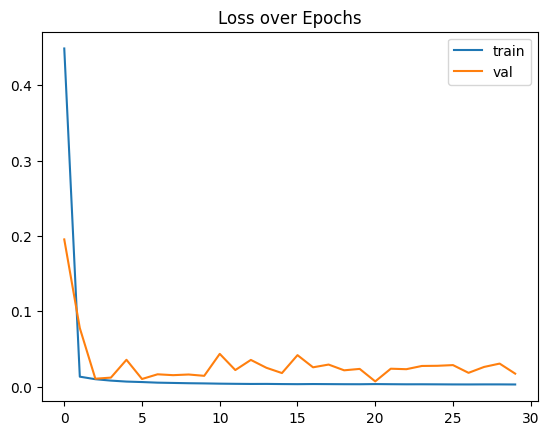

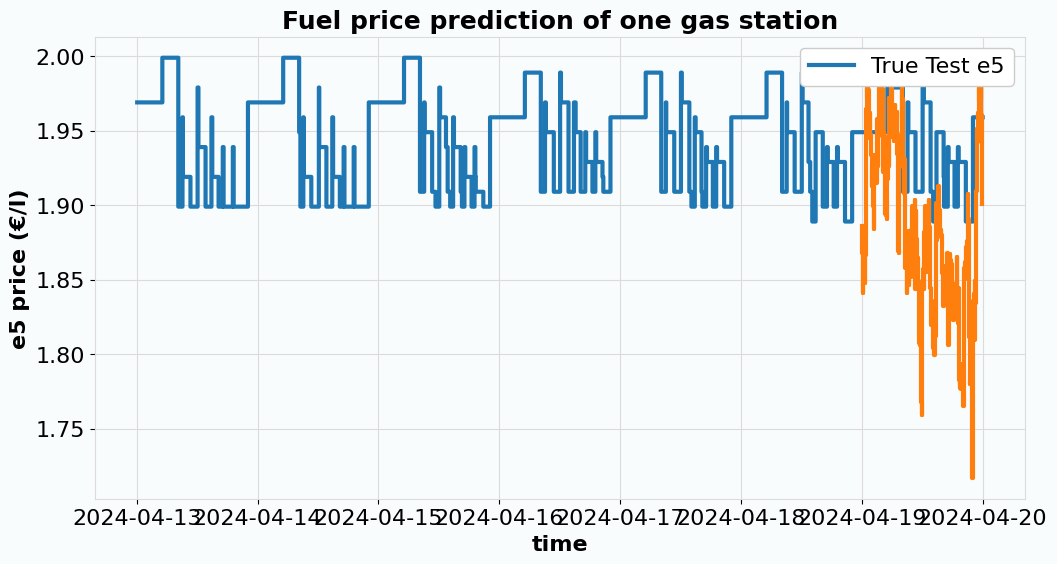

Successfully processed df12

Processing dataset: df13


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


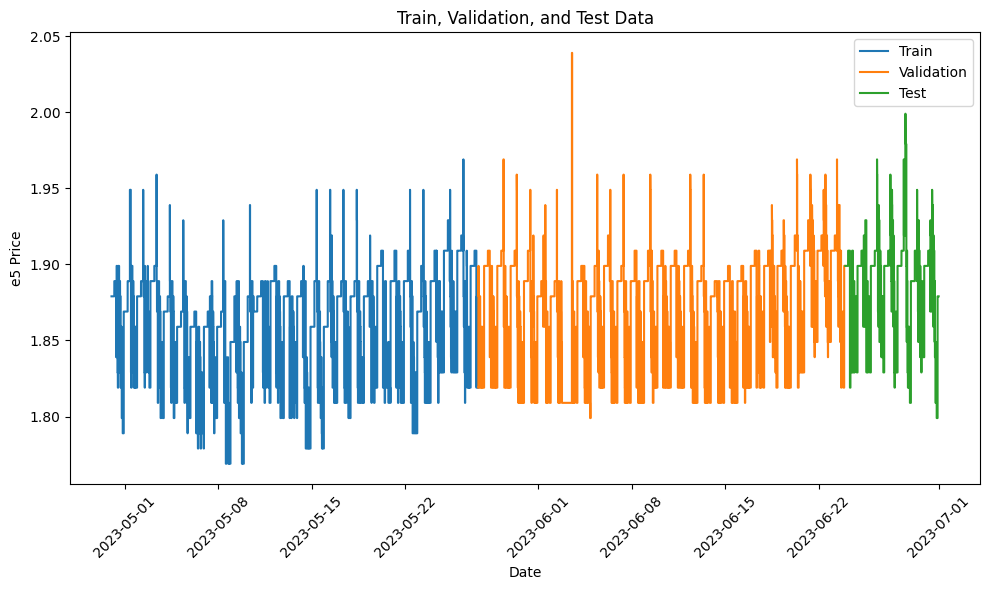

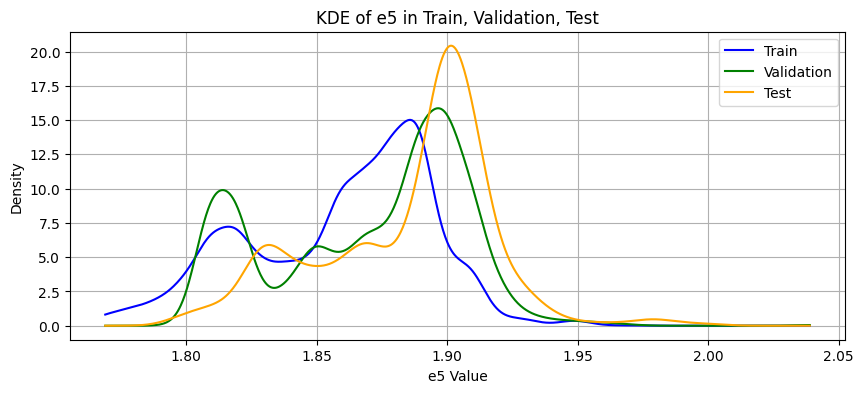

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-06-24 00:05:00 to 2023-06-30 00:00:00, to predict 1 day(s)
Test set range: 2023-06-24 00:05:00 to 2023-07-01 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.3811 - val_loss: 0.0669
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0303
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - val_loss: 0.0054
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.019213806270725206
                     Predicted E5
datetime                         
2023-06-30 00:00:00      1.880957
2023-06-30 00:05:00      1.883859
2023-06-30 00:10:00      1.888763
2023-06-30 00:15:00      1.892605
2023-06-30 00:20:00      1.892468


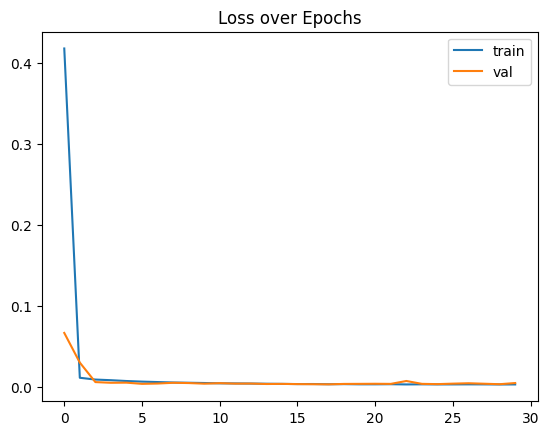

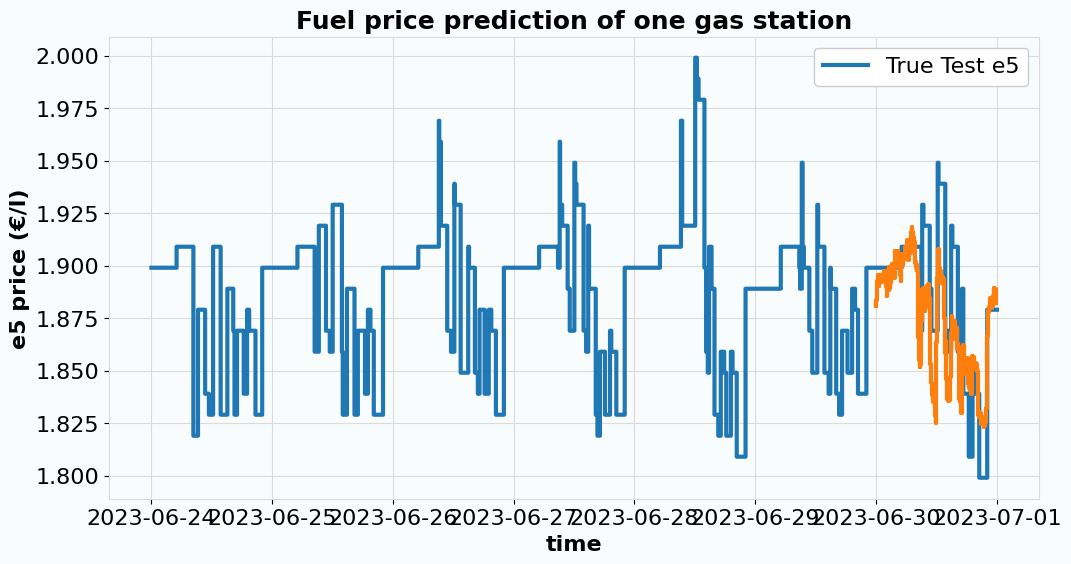

Successfully processed df13

Processing dataset: df14


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


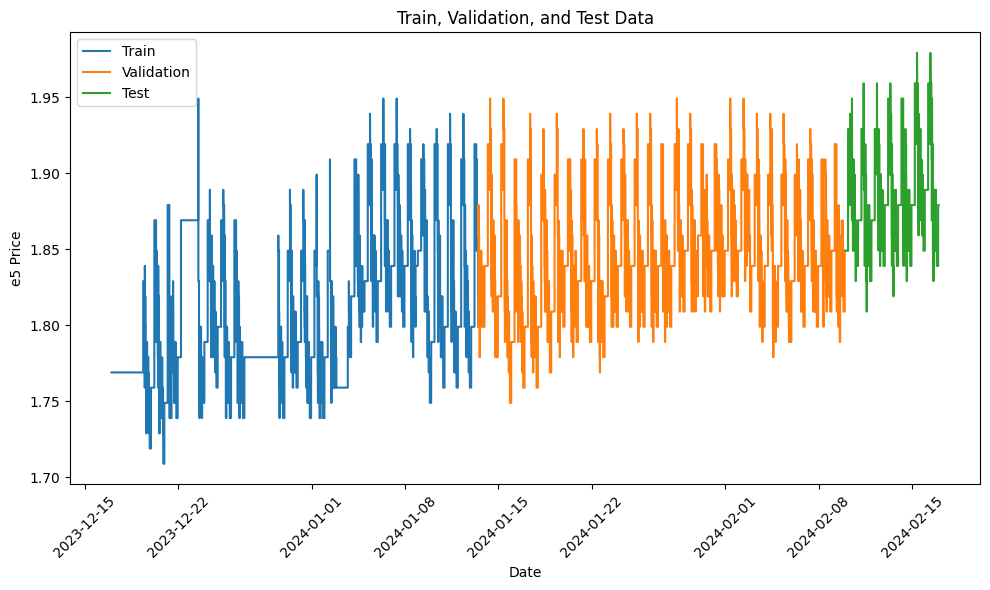

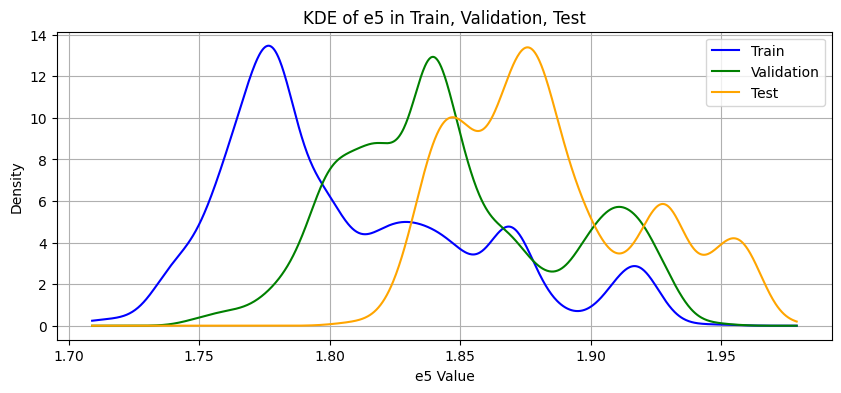

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-02-10 00:05:00 to 2024-02-16 00:00:00, to predict 1 day(s)
Test set range: 2024-02-10 00:05:00 to 2024-02-17 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.2276 - val_loss: 0.1324
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0125 - val_loss: 0.0391
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0104 - val_loss: 0.0147
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0087 - val_loss: 0.0035
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 1

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.03416490058104188
                     Predicted E5
datetime                         
2024-02-16 00:00:00      1.865777
2024-02-16 00:05:00      1.865435
2024-02-16 00:10:00      1.861047
2024-02-16 00:15:00      1.862584
2024-02-16 00:20:00      1.861929


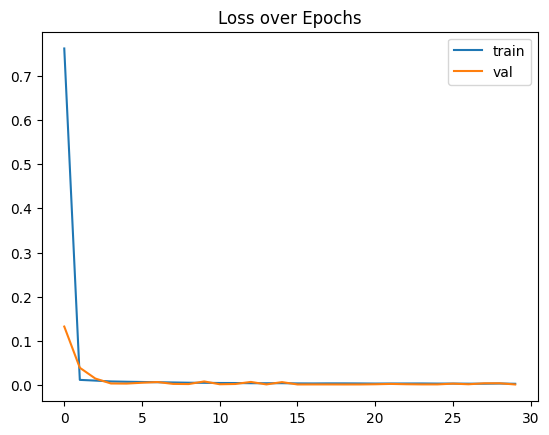

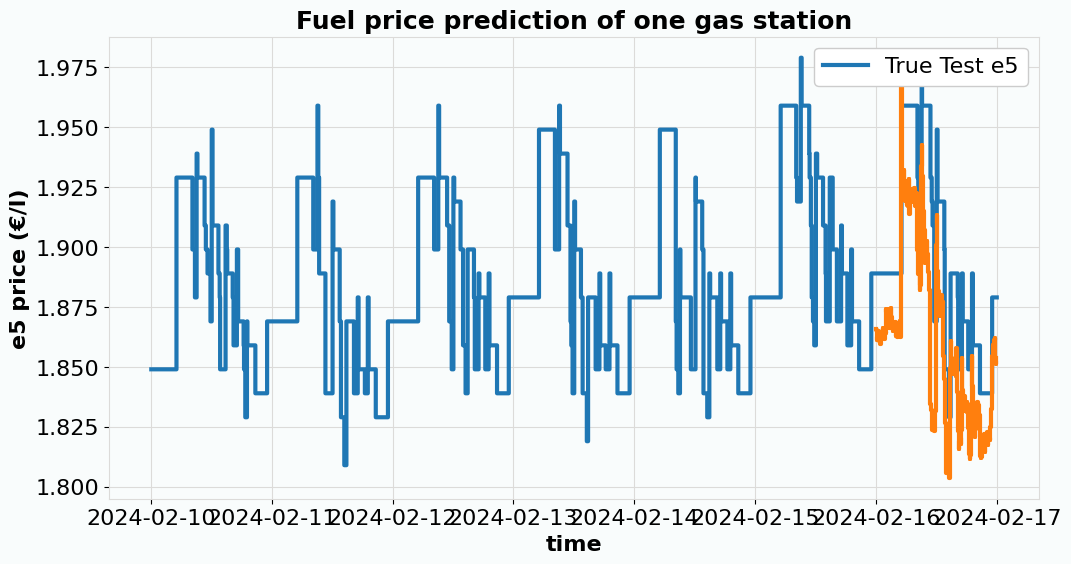

Successfully processed df14

Processing dataset: df15


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


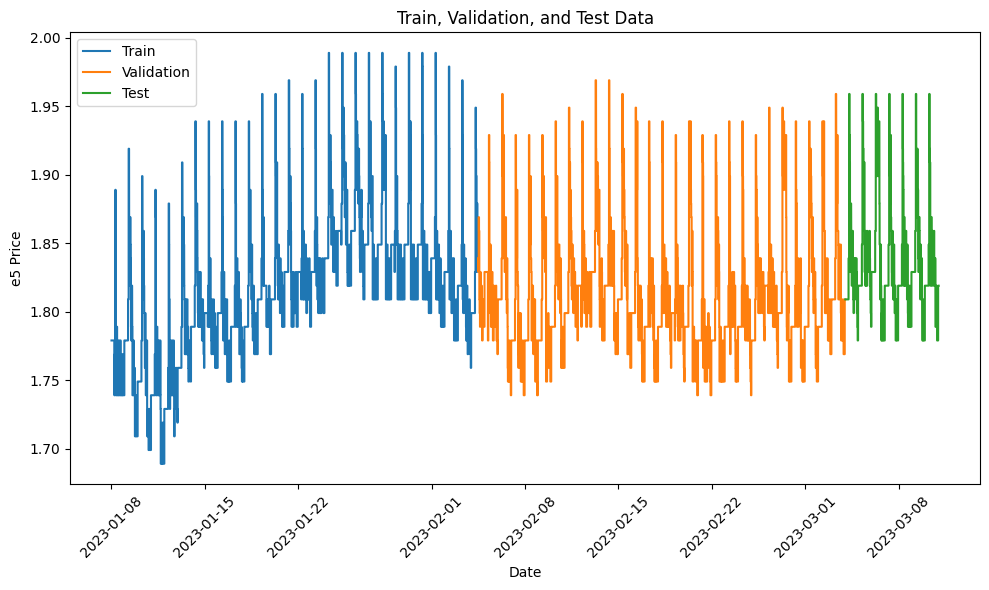

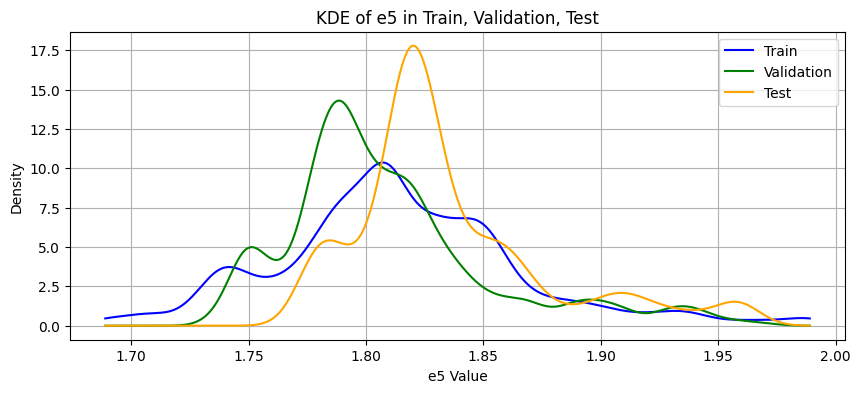

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-03-04 00:05:00 to 2023-03-10 00:00:00, to predict 1 day(s)
Test set range: 2023-03-04 00:05:00 to 2023-03-11 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.6373 - val_loss: 0.0302
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0121 - val_loss: 0.0144
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - val_loss: 0.0044
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0073 - val_loss: 0.0036
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.0157876629734205
                     Predicted E5
datetime                         
2023-03-10 00:00:00      1.820676
2023-03-10 00:05:00      1.823158
2023-03-10 00:10:00      1.823202
2023-03-10 00:15:00      1.819356
2023-03-10 00:20:00      1.817712


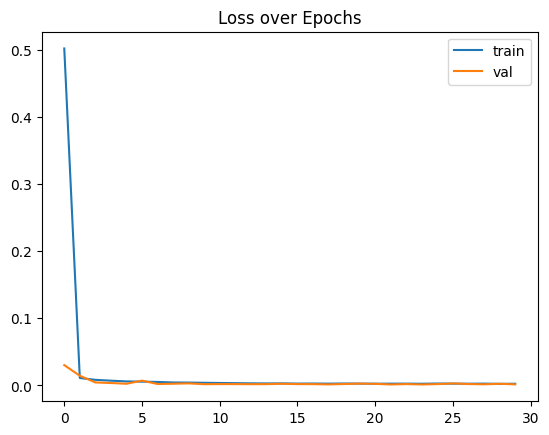

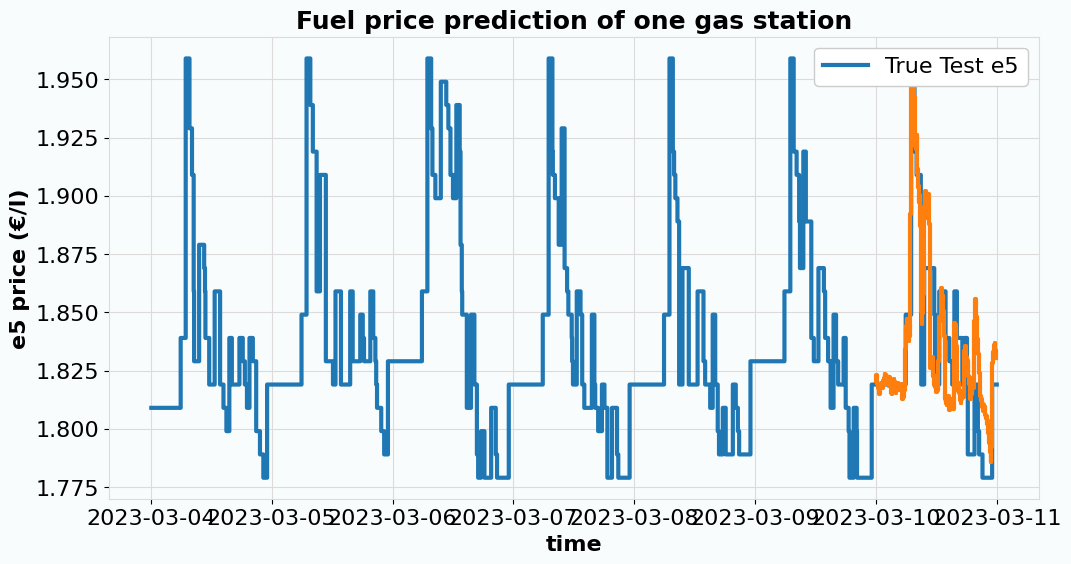

Successfully processed df15

Processing dataset: df16


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


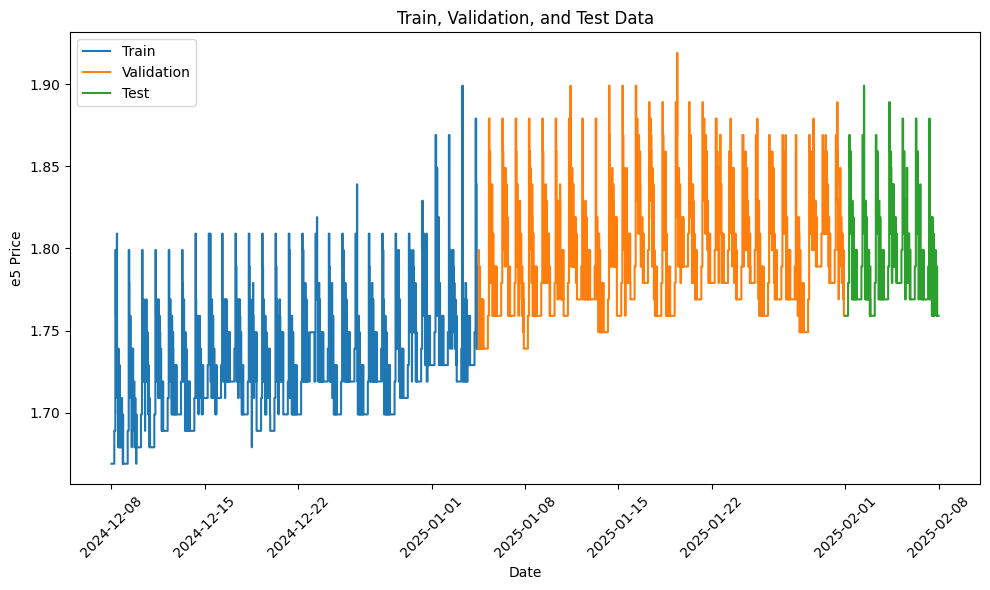

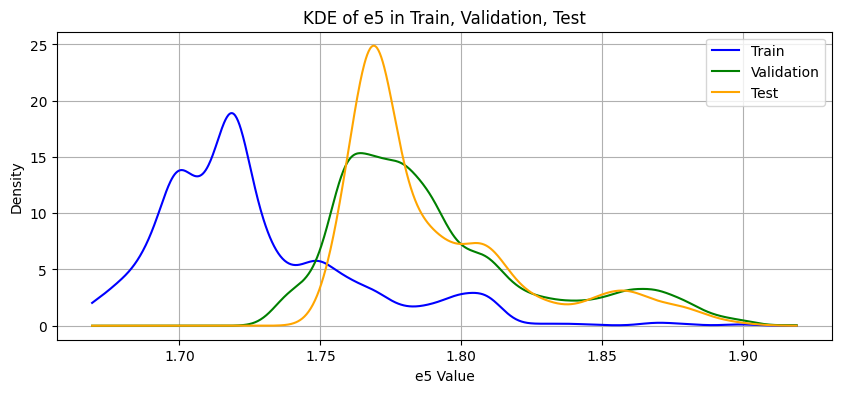

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2025-02-01 00:05:00 to 2025-02-07 00:00:00, to predict 1 day(s)
Test set range: 2025-02-01 00:05:00 to 2025-02-08 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5417 - val_loss: 0.1629
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0075 - val_loss: 0.0575
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0045 - val_loss: 0.0066
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0098
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0212
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0033 - val_loss: 0.0108
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0029 - val_loss: 0.0109
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - val_loss: 0.0103
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Forecast MSE: 0.018801347824434503
                     Predicted E5
datetime                         
2025-02-07 00:00:00      1.779822
2025-02-07 00:05:00      1.779148
2025-02-07 00:10:00      1.778638
2025-02-07 00:15:00      1.778608
2025-02-07 00:20:00      1.779304


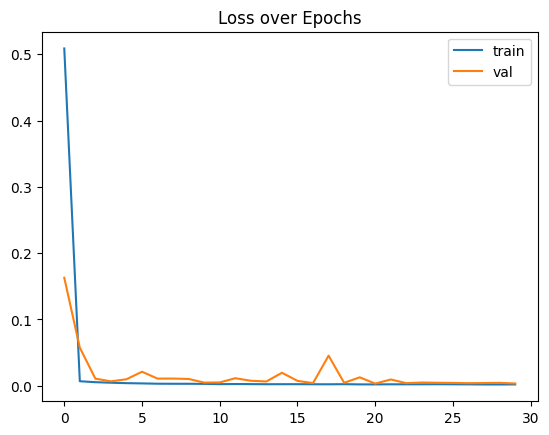

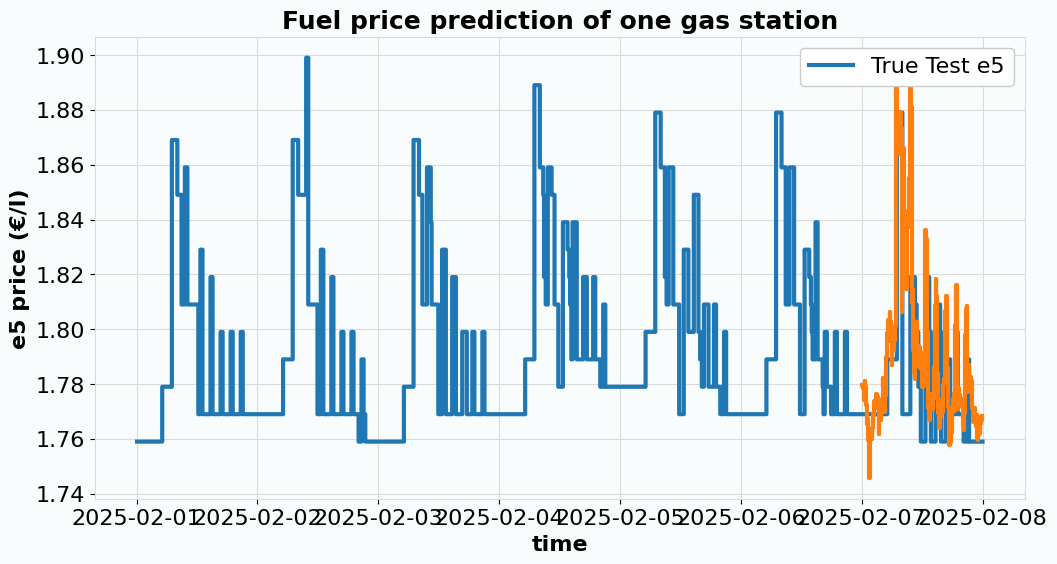

Successfully processed df16

Processing dataset: df17


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


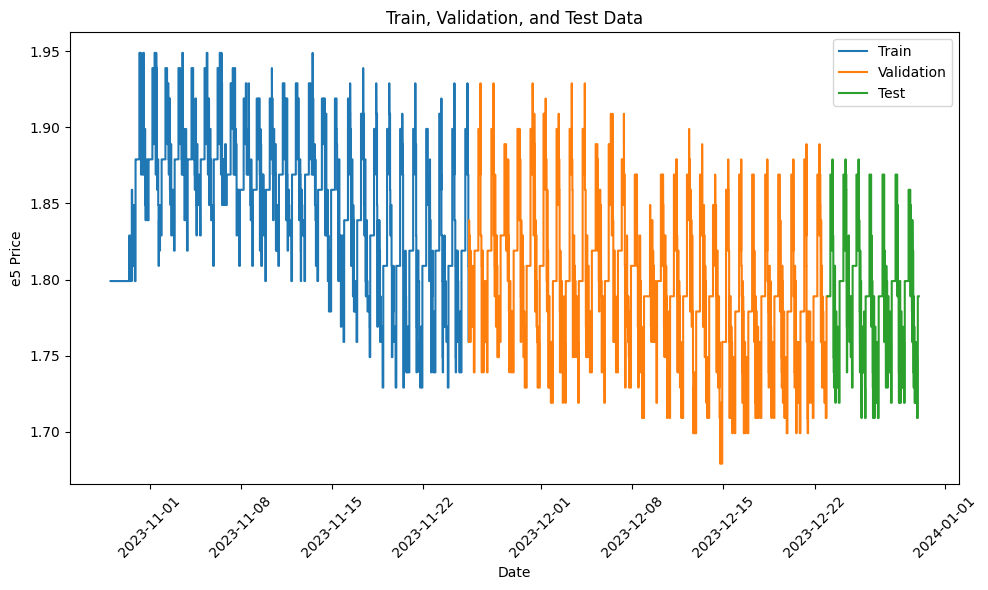

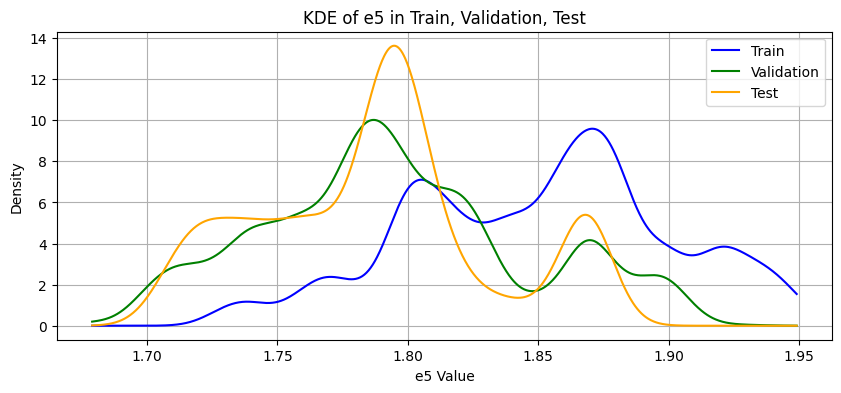

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-23 00:05:00 to 2023-12-29 00:00:00, to predict 1 day(s)
Test set range: 2023-12-23 00:05:00 to 2023-12-30 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.4026 - val_loss: 0.0633
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0196 - val_loss: 0.0149
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0134 - val_loss: 0.0201
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0110 - val_loss: 0.0670
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - val_loss: 0.0569
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0090 - val_loss: 0.0519
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 0.0528
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0067 - val_loss: 0.0436
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0061 - val_loss: 0.0396
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0060 - val_loss: 0.0336
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0057 - val_loss: 0.0342
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Forecast MSE: 0.024840887732182876
                     Predicted E5
datetime                         
2023-12-29 00:00:00      1.811264
2023-12-29 00:05:00      1.812383
2023-12-29 00:10:00      1.813746
2023-12-29 00:15:00      1.816636
2023-12-29 00:20:00      1.816199


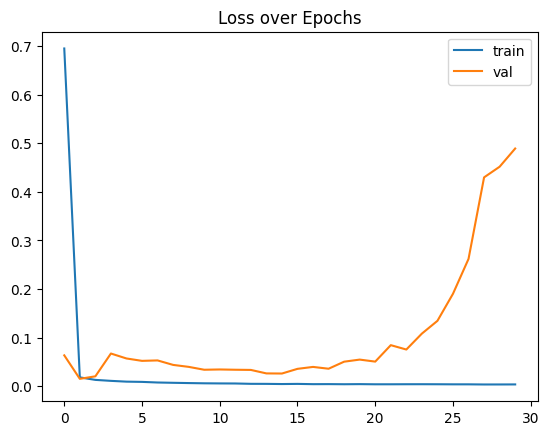

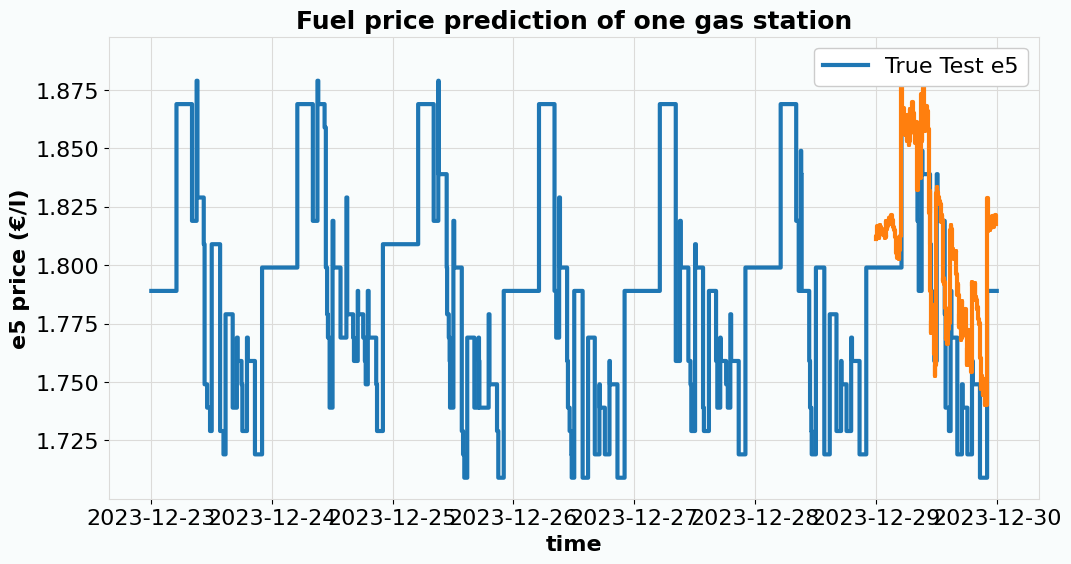

Successfully processed df17

Processing dataset: df18


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


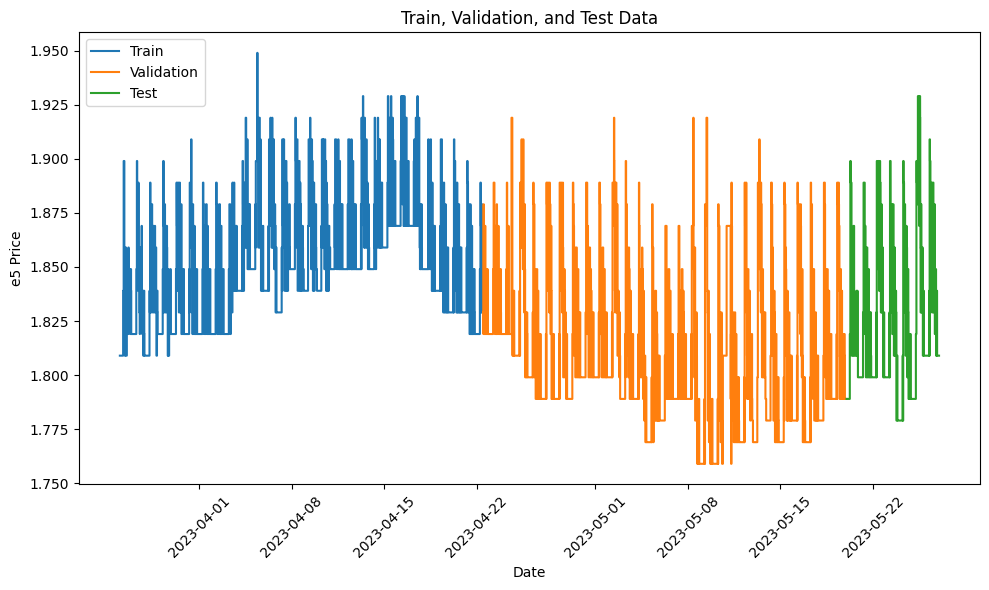

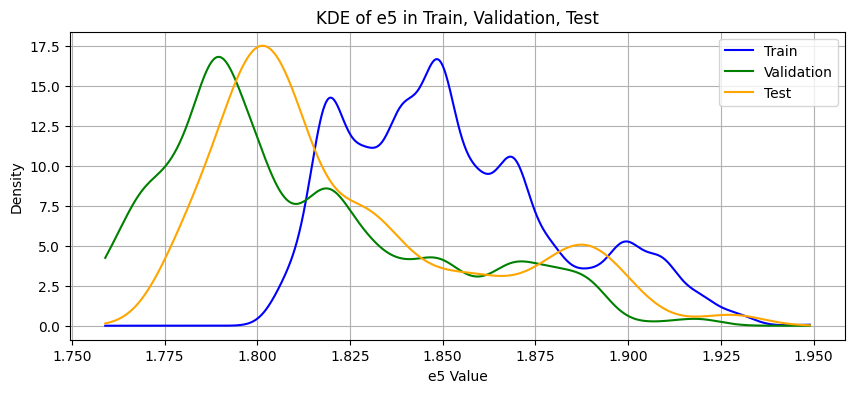

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-05-20 00:05:00 to 2023-05-26 00:00:00, to predict 1 day(s)
Test set range: 2023-05-20 00:05:00 to 2023-05-27 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5137 - val_loss: 0.0639
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0142 - val_loss: 5.1755
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120 - val_loss: 43.4127
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - val_loss: 70.6342
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0083 - val_loss: 80.0587
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0073 - val_loss: 80.2098
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - val_loss: 76.7591
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0063 - val_loss: 75.4412
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0055 - val_loss: 72.4874
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0052 - val_loss: 78.0927
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 77.2437
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.4710130145587031
                     Predicted E5
datetime                         
2023-05-26 00:00:00      1.072238
2023-05-26 00:05:00      0.968487
2023-05-26 00:10:00      1.003488
2023-05-26 00:15:00      1.228293
2023-05-26 00:20:00      1.262402


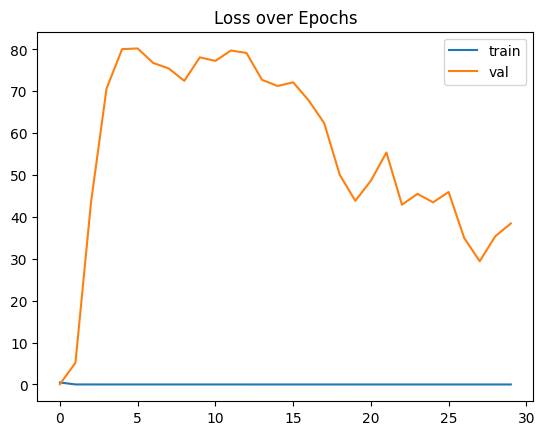

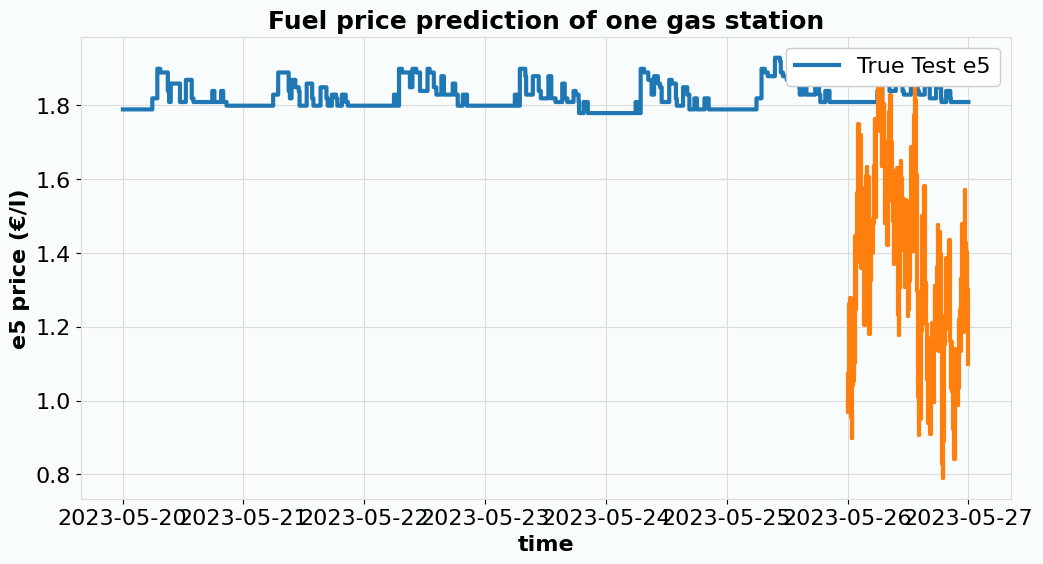

Successfully processed df18

Processing dataset: df19


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


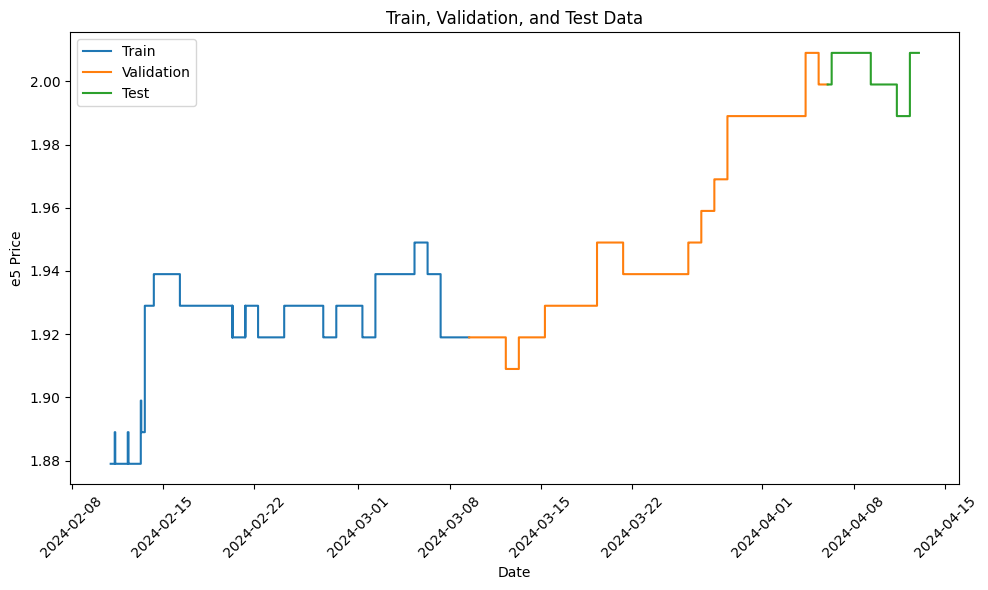

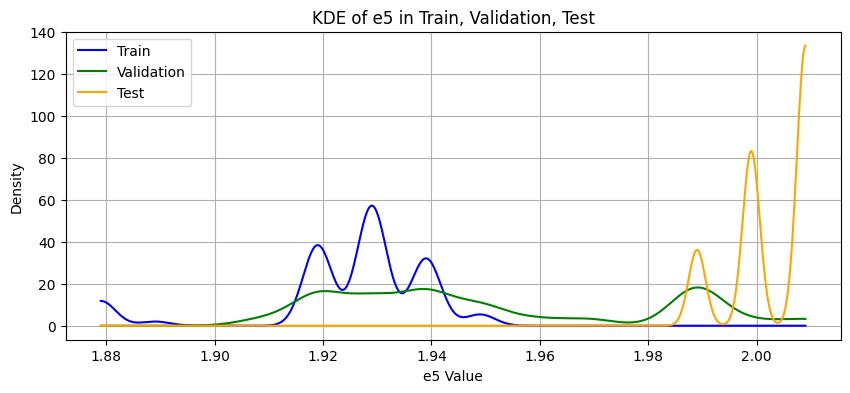

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-04-06 00:05:00 to 2024-04-12 00:00:00, to predict 1 day(s)
Test set range: 2024-04-06 00:05:00 to 2024-04-13 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.7659 - val_loss: 0.6504
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0241 - val_loss: 0.2037
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0164 - val_loss: 0.0818
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0148 - val_loss: 0.0725
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0126 - val_loss: 0.1160
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0108 - val_loss: 0.0269
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0094 - val_loss: 0.0588
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0077 - val_loss: 0.0585
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0075 - val_loss: 0.0863
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0065 - val_loss: 0.0579
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0065 - val_loss: 0.0437
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forecast MSE: 0.06366389301915959
                     Predicted E5
datetime                         
2024-04-12 00:00:00      1.962806
2024-04-12 00:05:00      1.965713
2024-04-12 00:10:00      1.965682
2024-04-12 00:15:00      1.967570
2024-04-12 00:20:00      1.967110


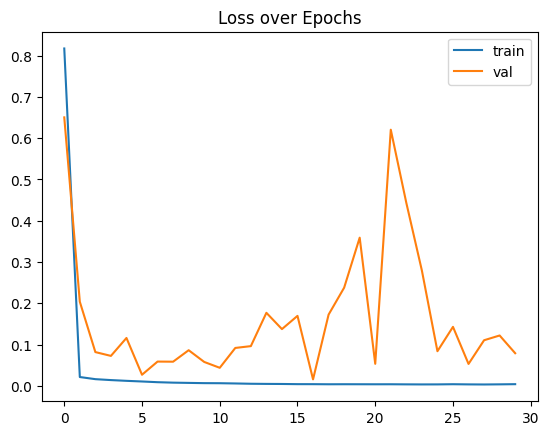

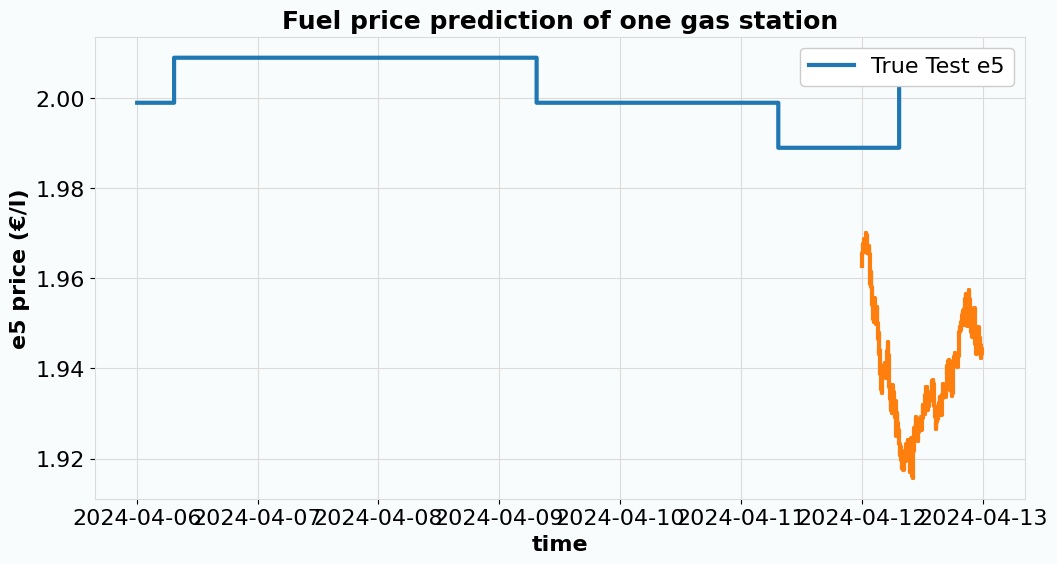

Successfully processed df19

Processing dataset: df20


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


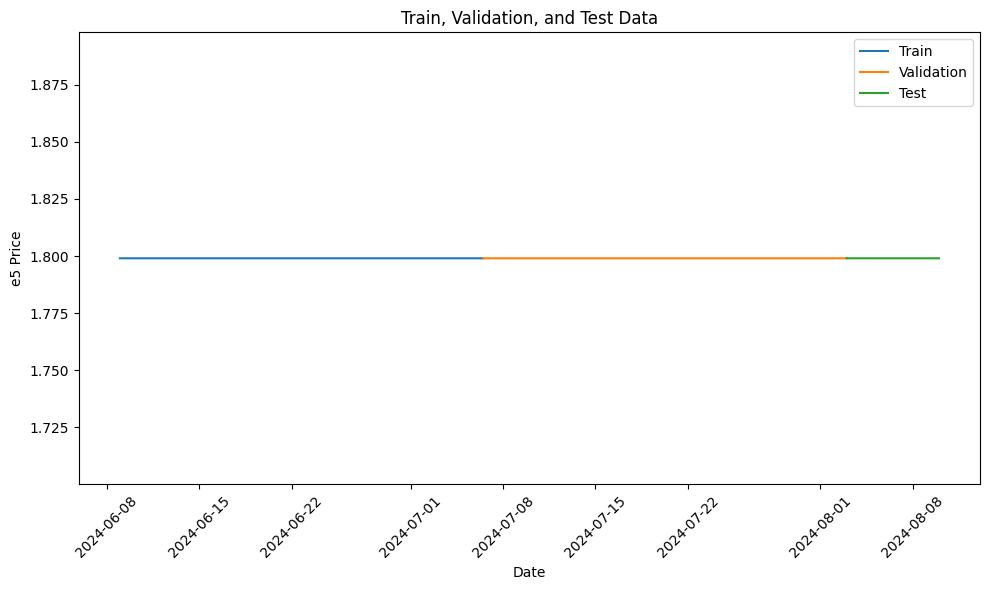

Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

Processing dataset: df21


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


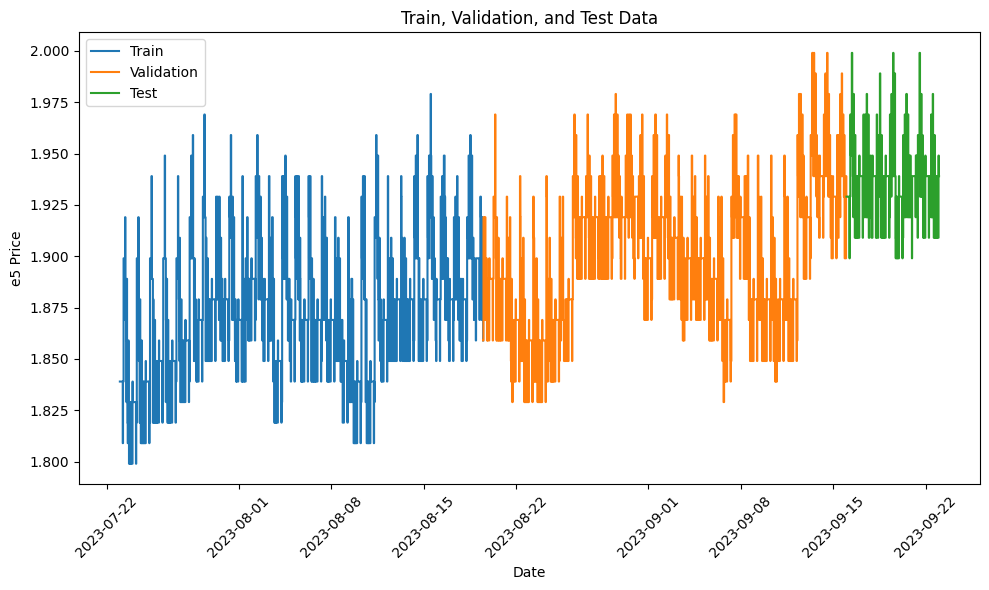

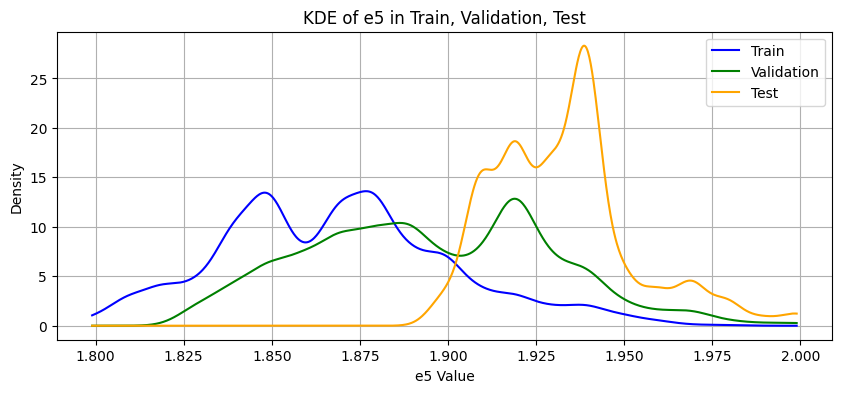

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-09-16 00:05:00 to 2023-09-22 00:00:00, to predict 1 day(s)
Test set range: 2023-09-16 00:05:00 to 2023-09-23 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8045 - val_loss: 0.0747
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0105 - val_loss: 0.0247
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0039 - val_loss: 0.0075
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Forecast MSE: 0.01547610167827881
                     Predicted E5
datetime                         
2023-09-22 00:00:00      1.948509
2023-09-22 00:05:00      1.953672
2023-09-22 00:10:00      1.957939
2023-09-22 00:15:00      1.957027
2023-09-22 00:20:00      1.954792


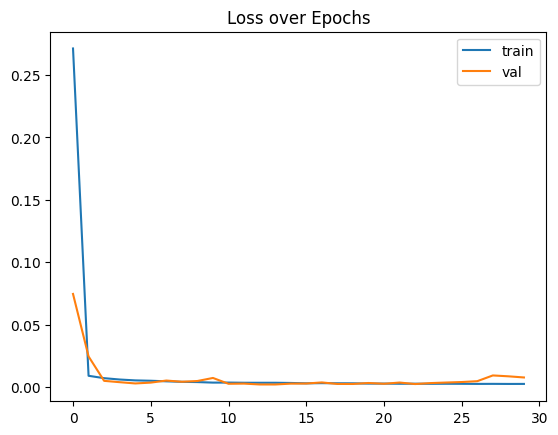

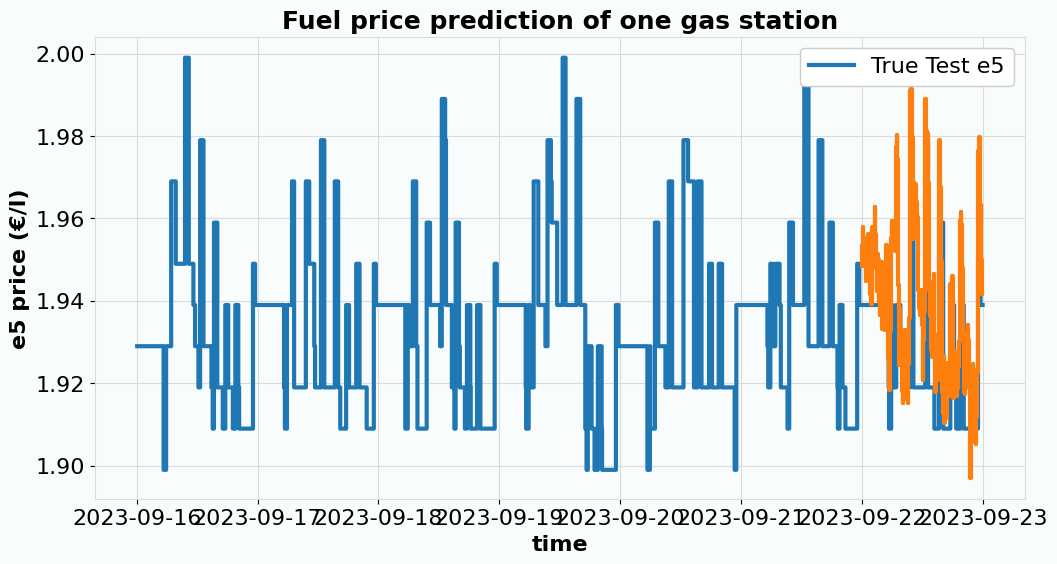

Successfully processed df21

Processing dataset: df22


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


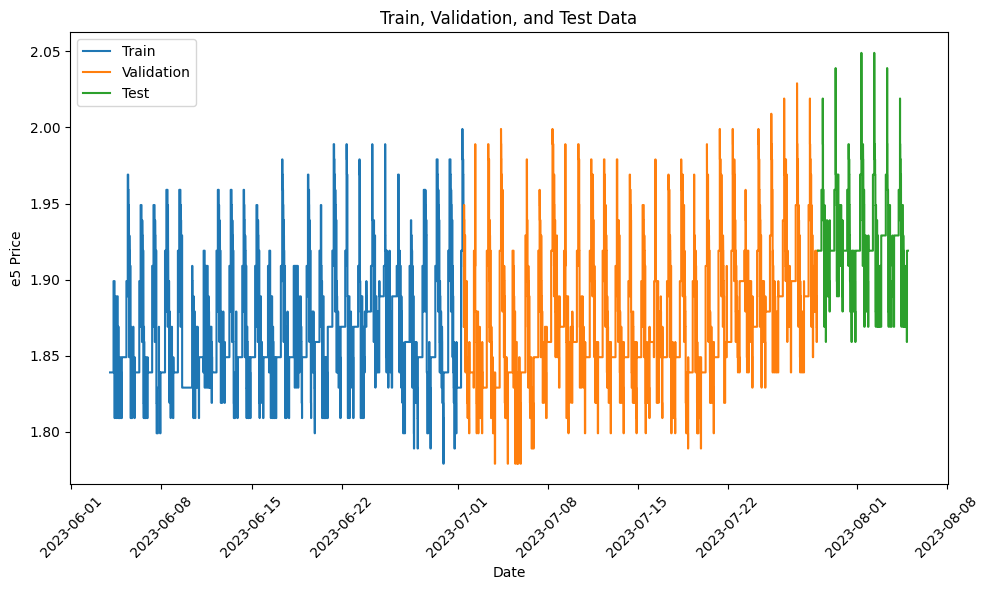

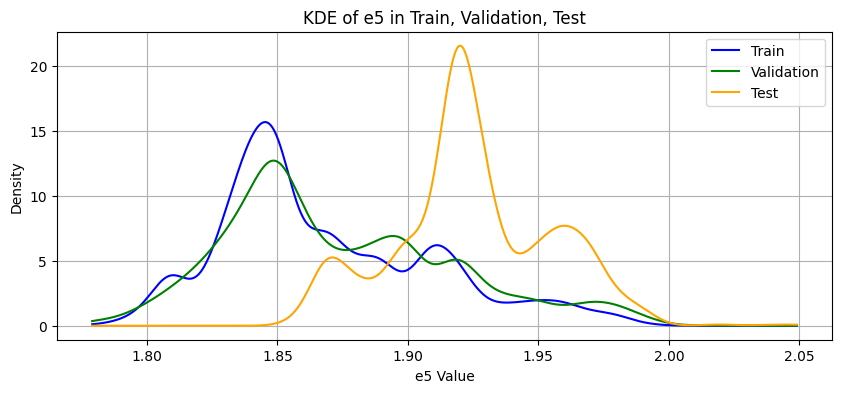

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-07-29 00:05:00 to 2023-08-04 00:00:00, to predict 1 day(s)
Test set range: 2023-07-29 00:05:00 to 2023-08-05 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5440 - val_loss: 0.1001
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0118 - val_loss: 0.0321
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0075 - val_loss: 0.0032
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.02291313940866129
                     Predicted E5
datetime                         
2023-08-04 00:00:00      1.922704
2023-08-04 00:05:00      1.921733
2023-08-04 00:10:00      1.923141
2023-08-04 00:15:00      1.926126
2023-08-04 00:20:00      1.928096


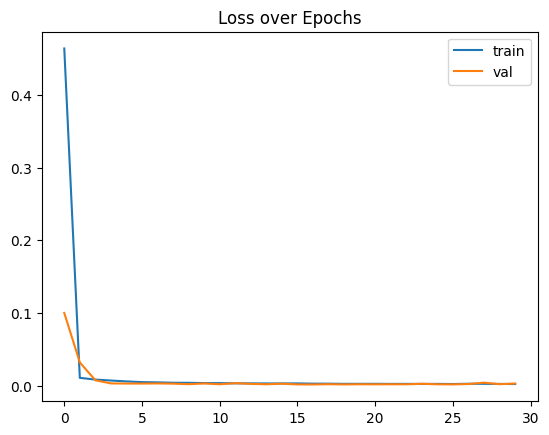

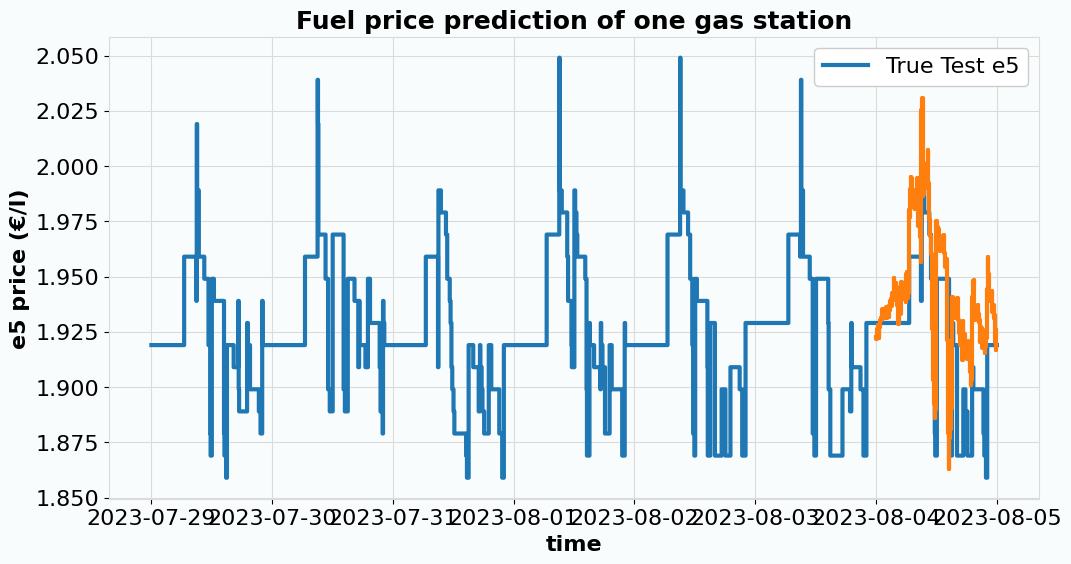

Successfully processed df22

Processing dataset: df23


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


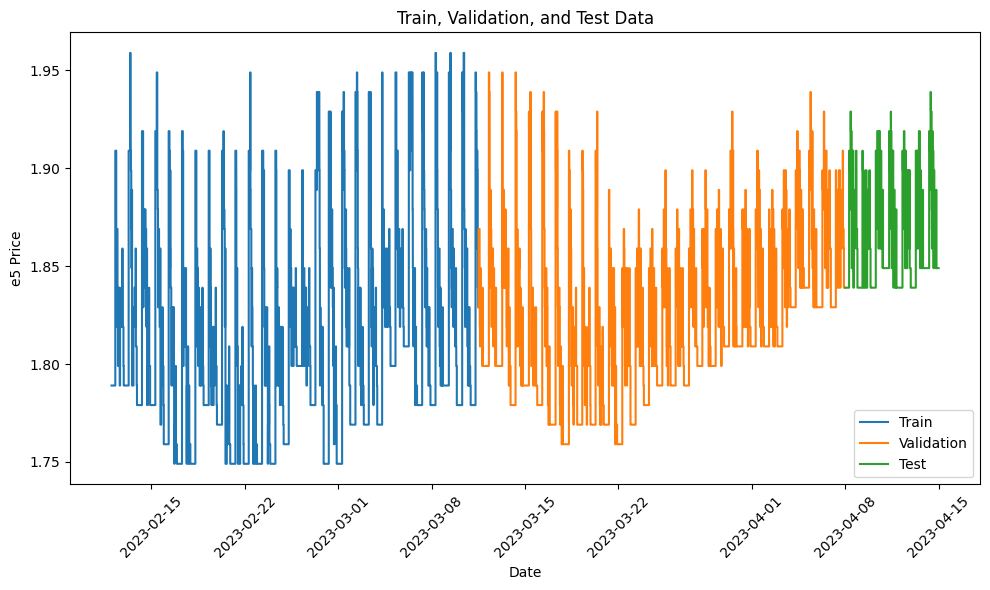

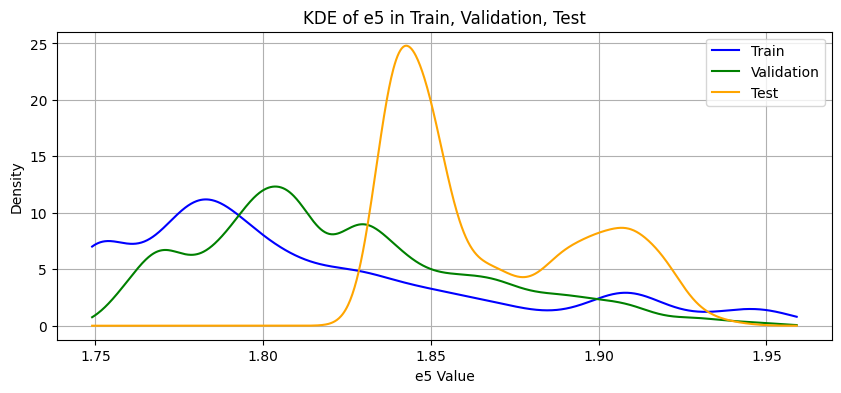

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-04-08 00:05:00 to 2023-04-14 00:00:00, to predict 1 day(s)
Test set range: 2023-04-08 00:05:00 to 2023-04-15 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.4916 - val_loss: 0.0555
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0126 - val_loss: 0.0252
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0102 - val_loss: 0.0046
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Forecast MSE: 0.017542655756696945
                     Predicted E5
datetime                         
2023-04-14 00:00:00      1.835675
2023-04-14 00:05:00      1.838261
2023-04-14 00:10:00      1.836945
2023-04-14 00:15:00      1.837935
2023-04-14 00:20:00      1.838907


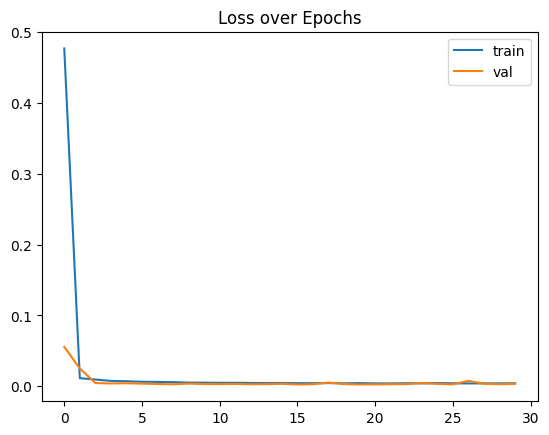

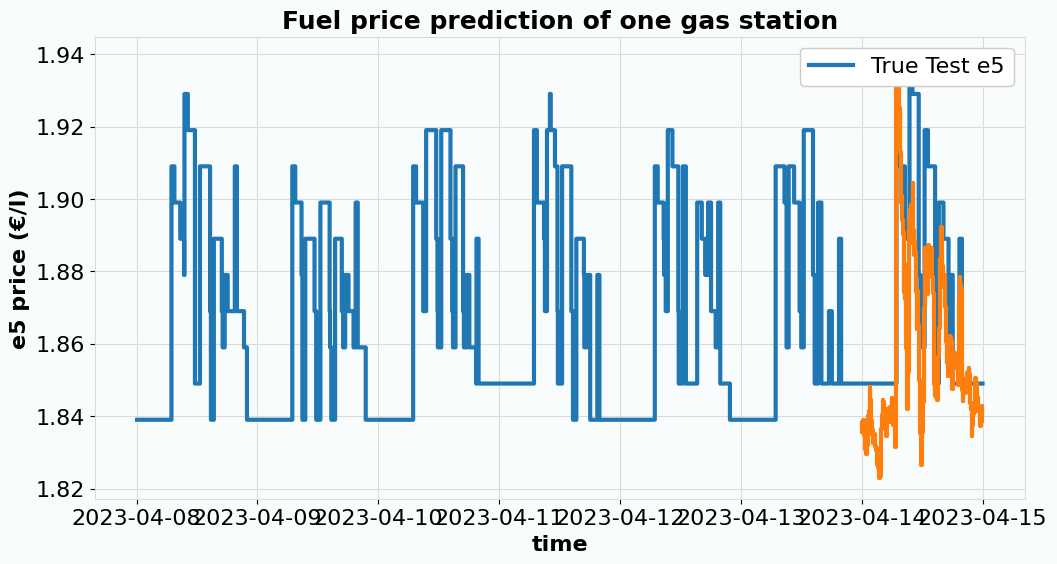

Successfully processed df23

Processing dataset: df24


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


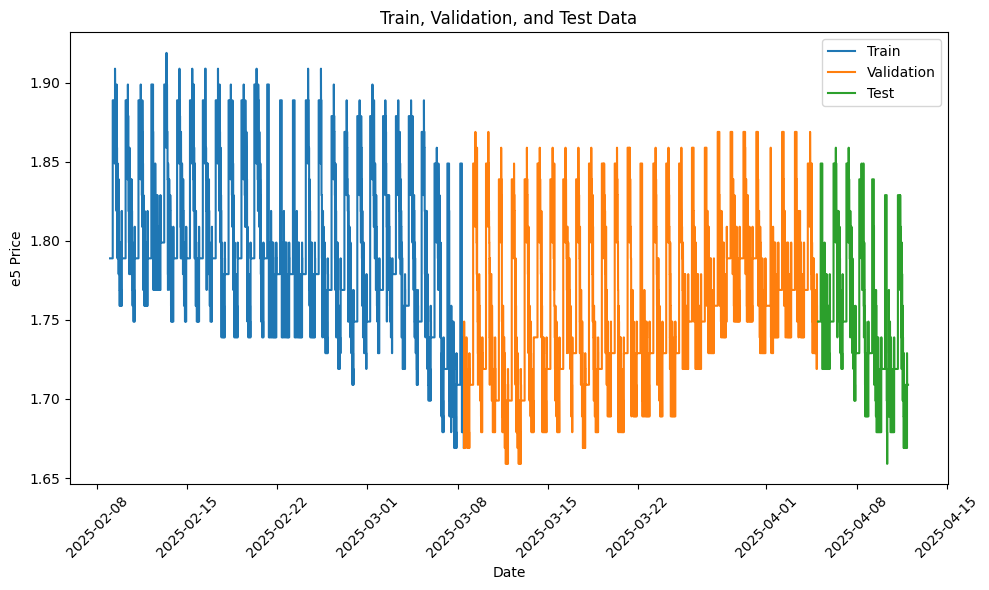

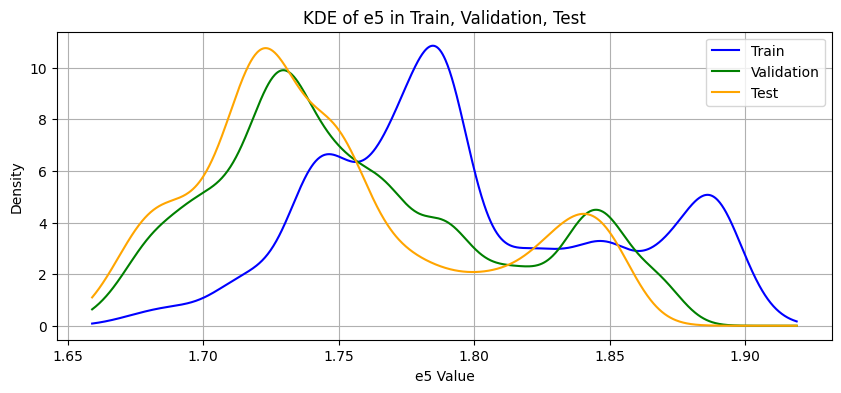

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2025-04-05 00:05:00 to 2025-04-11 00:00:00, to predict 1 day(s)
Test set range: 2025-04-05 00:05:00 to 2025-04-12 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.3690 - val_loss: 0.0383
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0135 - val_loss: 0.0173
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - val_loss: 0.0056
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.036845538130340465
                     Predicted E5
datetime                         
2025-04-11 00:00:00      1.750602
2025-04-11 00:05:00      1.748162
2025-04-11 00:10:00      1.747395
2025-04-11 00:15:00      1.749642
2025-04-11 00:20:00      1.745446


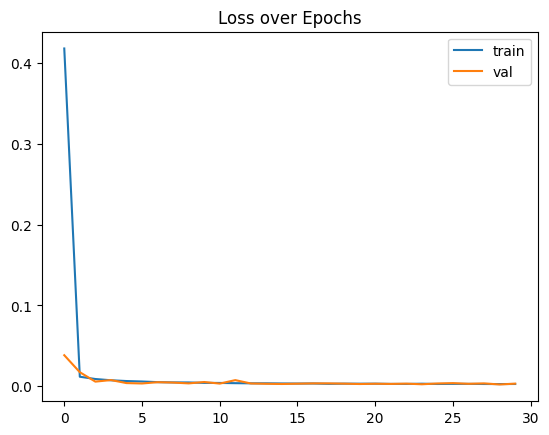

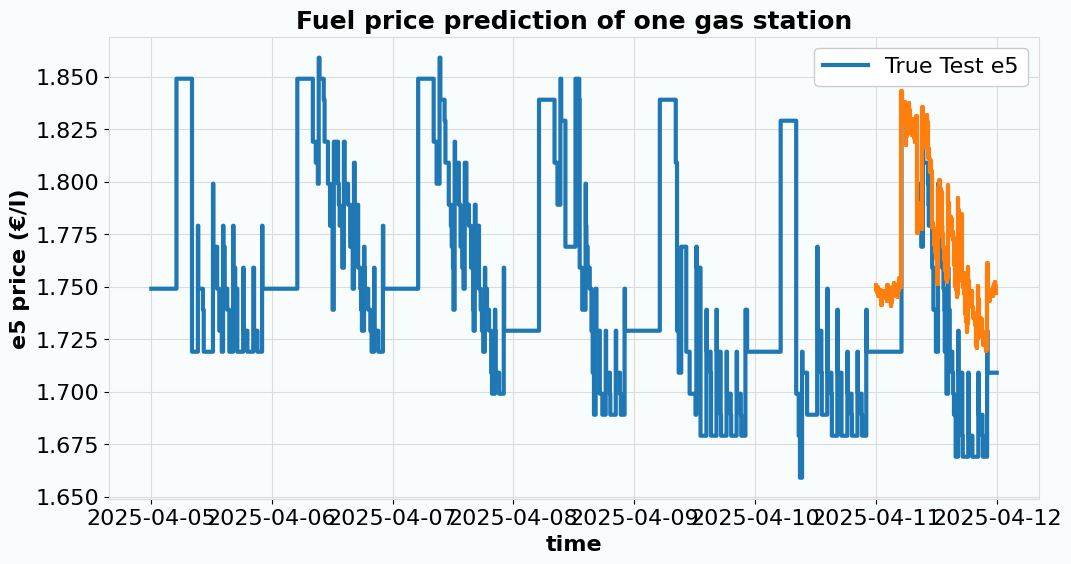

Successfully processed df24

Processing dataset: df25


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


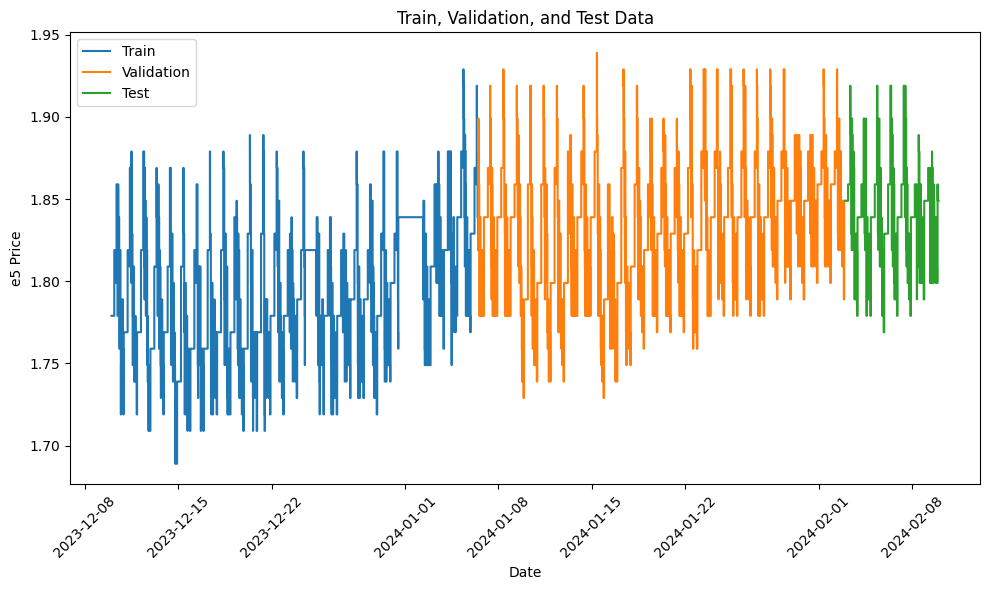

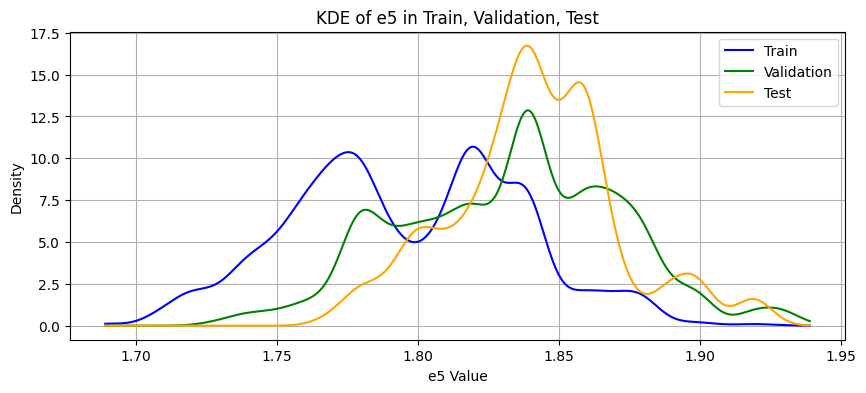

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-02-03 00:05:00 to 2024-02-09 00:00:00, to predict 1 day(s)
Test set range: 2024-02-03 00:05:00 to 2024-02-10 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6810 - val_loss: 0.1424
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0124 - val_loss: 0.0483
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Forecast MSE: 0.018607629703150882
                     Predicted E5
datetime                         
2024-02-09 00:00:00      1.854462
2024-02-09 00:05:00      1.849278
2024-02-09 00:10:00      1.846424
2024-02-09 00:15:00      1.847818
2024-02-09 00:20:00      1.852277


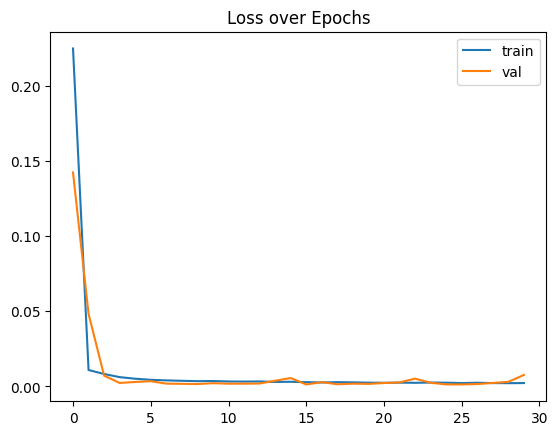

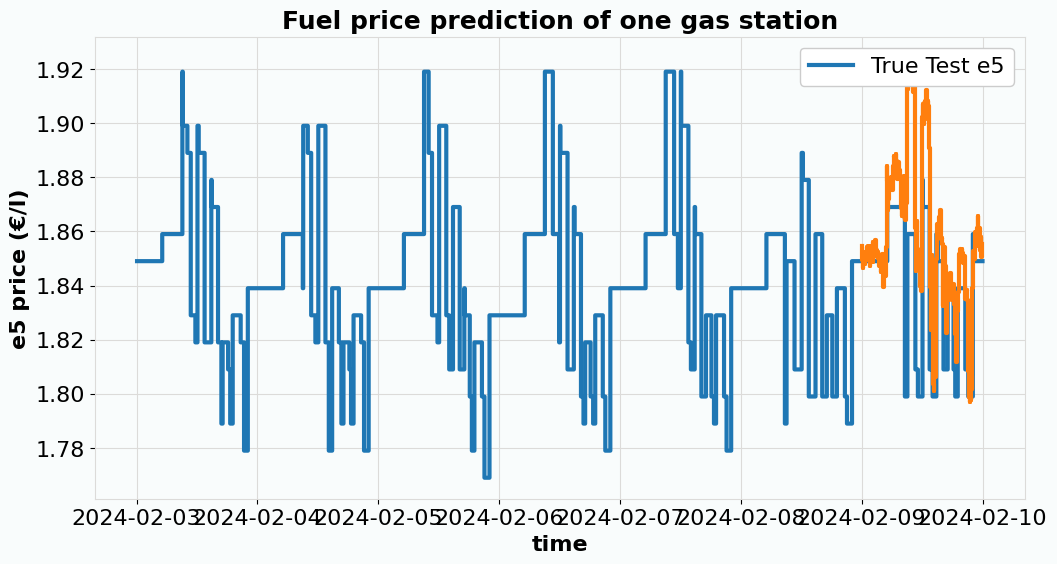

Successfully processed df25

Processing dataset: df26


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


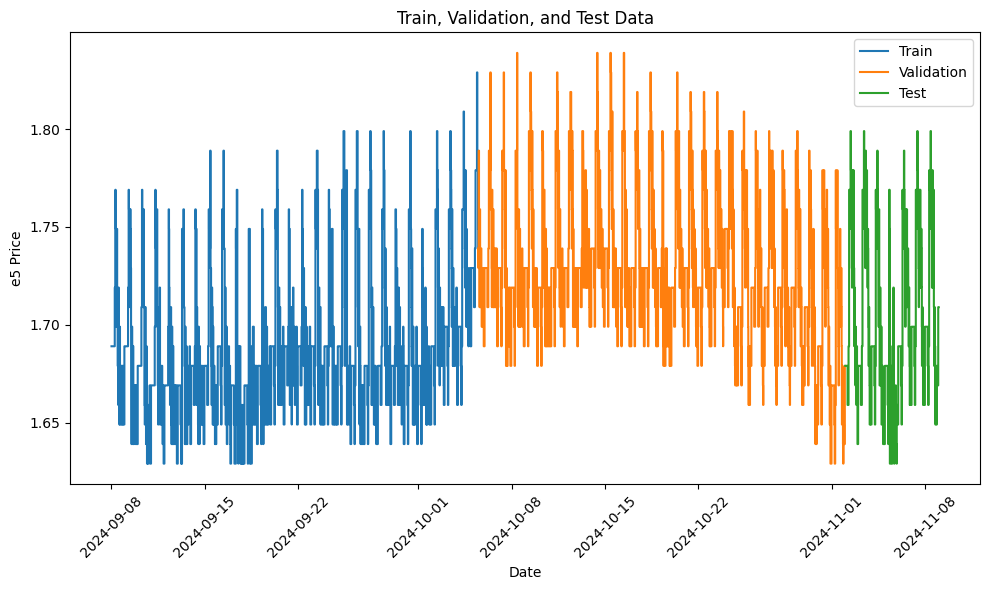

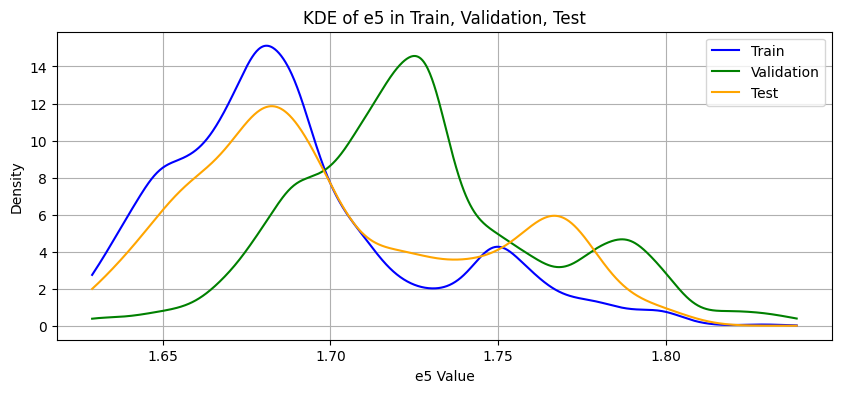

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-11-02 00:05:00 to 2024-11-08 00:00:00, to predict 1 day(s)
Test set range: 2024-11-02 00:05:00 to 2024-11-09 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.8930 - val_loss: 0.1534
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0121 - val_loss: 0.0569
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - val_loss: 0.0098
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0061 - val_loss: 0.0141
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Forecast MSE: 0.016191742726498197
                     Predicted E5
datetime                         
2024-11-08 00:00:00      1.682086
2024-11-08 00:05:00      1.681986
2024-11-08 00:10:00      1.682349
2024-11-08 00:15:00      1.681824
2024-11-08 00:20:00      1.682417


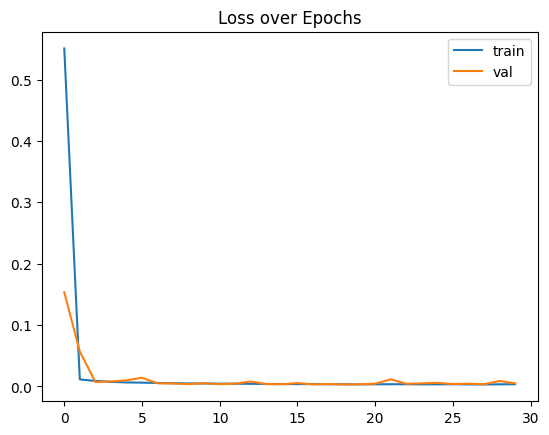

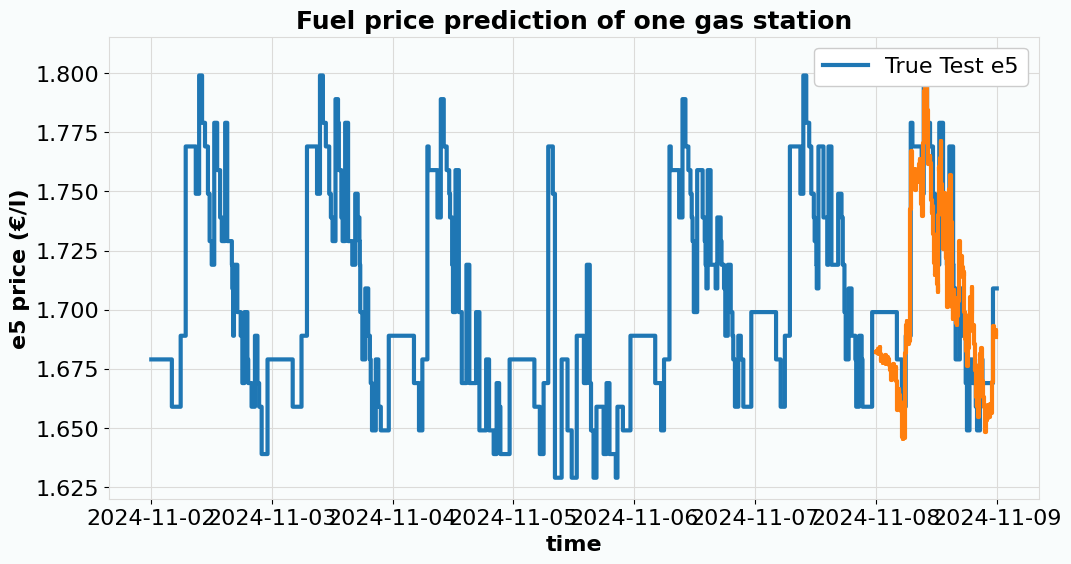

Successfully processed df26

Processing dataset: df27


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


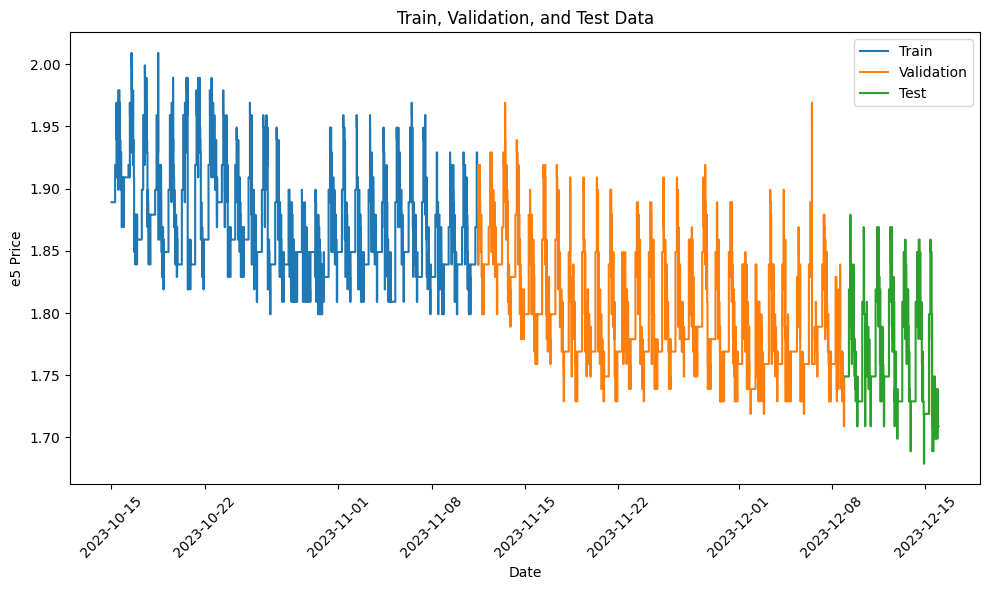

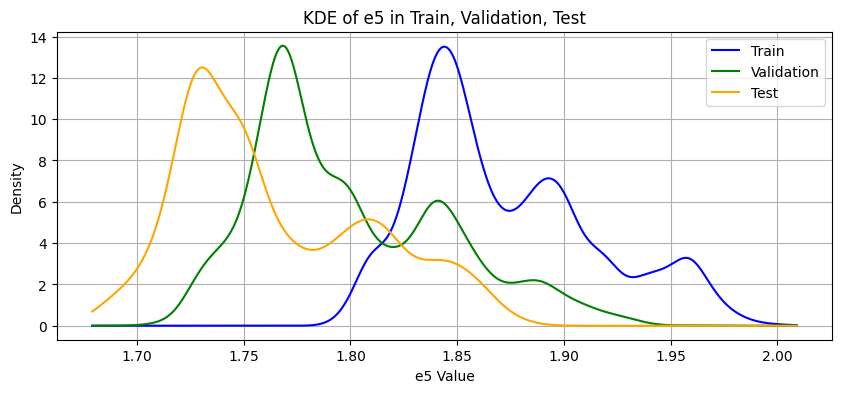

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-12-09 00:05:00 to 2023-12-15 00:00:00, to predict 1 day(s)
Test set range: 2023-12-09 00:05:00 to 2023-12-16 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.6850 - val_loss: 0.0452
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0159 - val_loss: 0.3072
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0101 - val_loss: 6.1254
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - val_loss: 11.7658
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0070 - val_loss: 11.7183
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0066 - val_loss: 12.1547
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - val_loss: 9.6968
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0059 - val_loss: 10.8520
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0053 - val_loss: 10.4613
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 11.7368
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 11.7430
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Forecast MSE: 3.4079171365168355
                     Predicted E5
datetime                         
2023-12-15 00:00:00     -1.426703
2023-12-15 00:05:00     -1.335555
2023-12-15 00:10:00     -1.307766
2023-12-15 00:15:00     -1.358291
2023-12-15 00:20:00     -1.361800


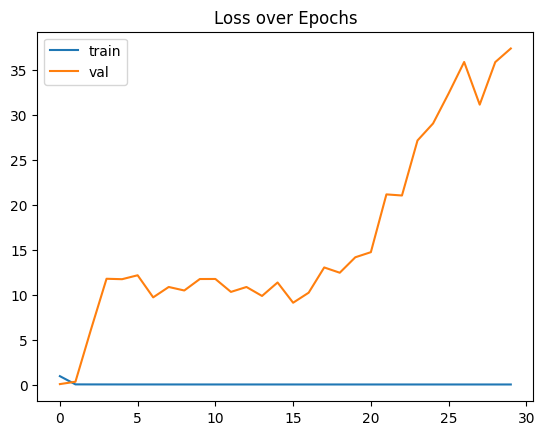

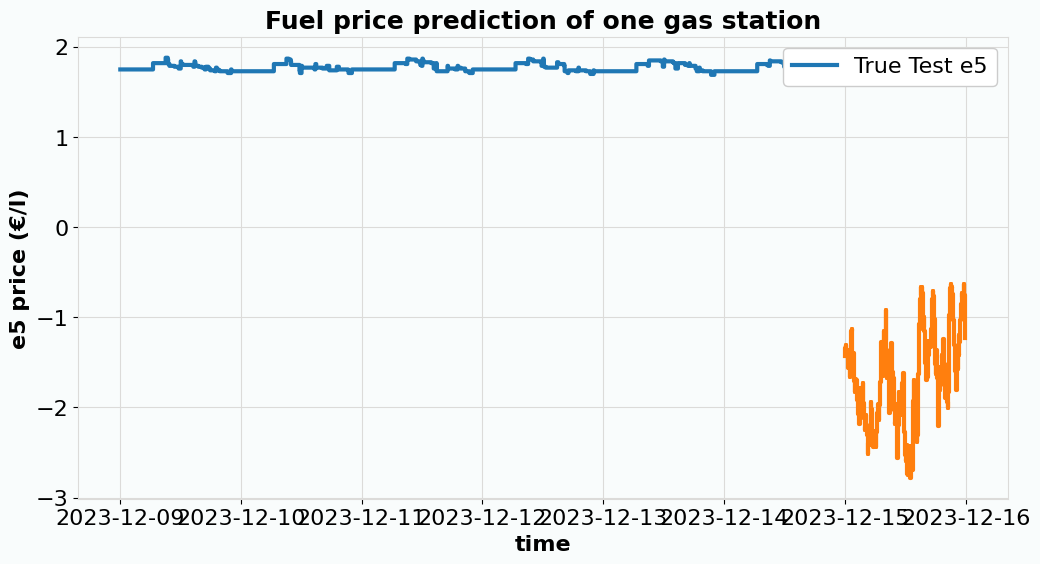

Successfully processed df27

Processing dataset: df28


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


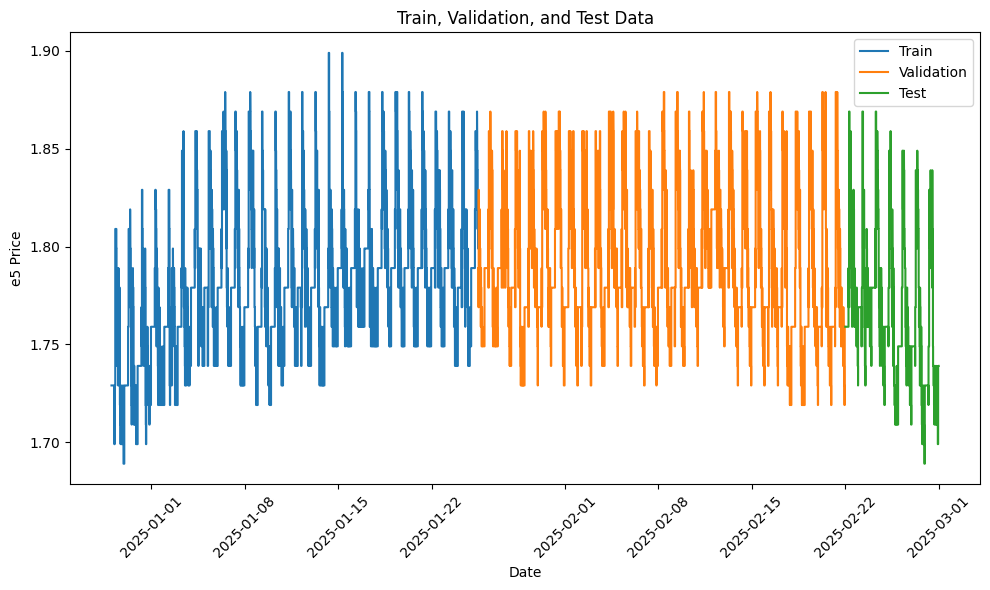

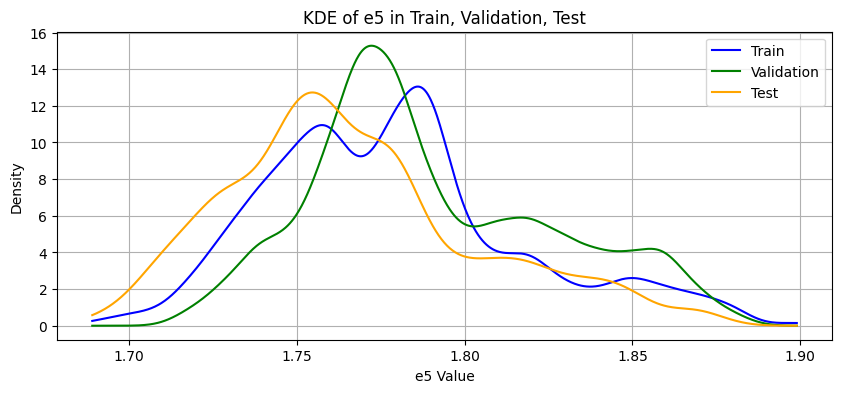

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2025-02-22 00:05:00 to 2025-02-28 00:00:00, to predict 1 day(s)
Test set range: 2025-02-22 00:05:00 to 2025-03-01 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.8256 - val_loss: 0.0670
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0117 - val_loss: 0.0220
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0078 - val_loss: 0.0036
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Forecast MSE: 0.03902549365897553
                     Predicted E5
datetime                         
2025-02-28 00:00:00      1.776102
2025-02-28 00:05:00      1.775214
2025-02-28 00:10:00      1.772887
2025-02-28 00:15:00      1.773211
2025-02-28 00:20:00      1.773646


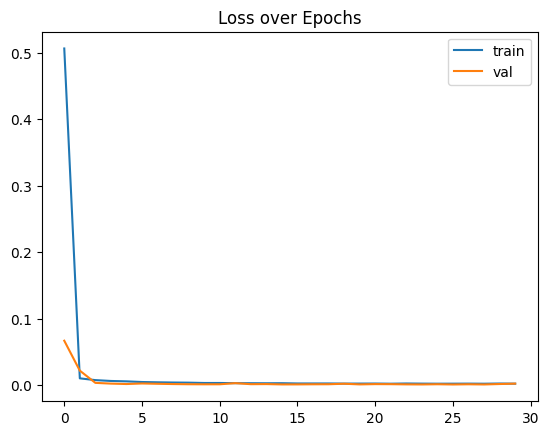

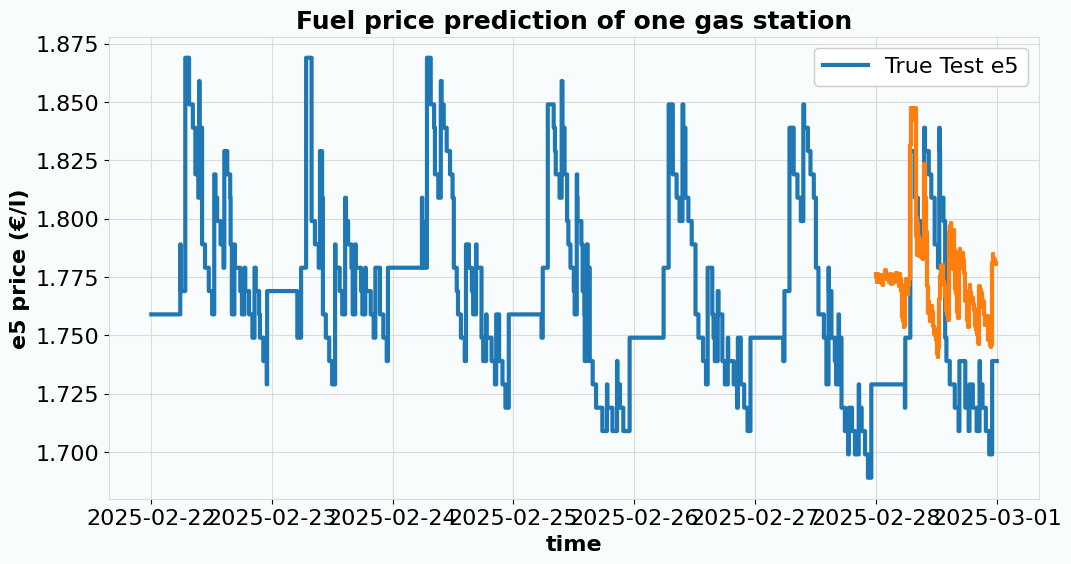

Successfully processed df28

Processing dataset: df29


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


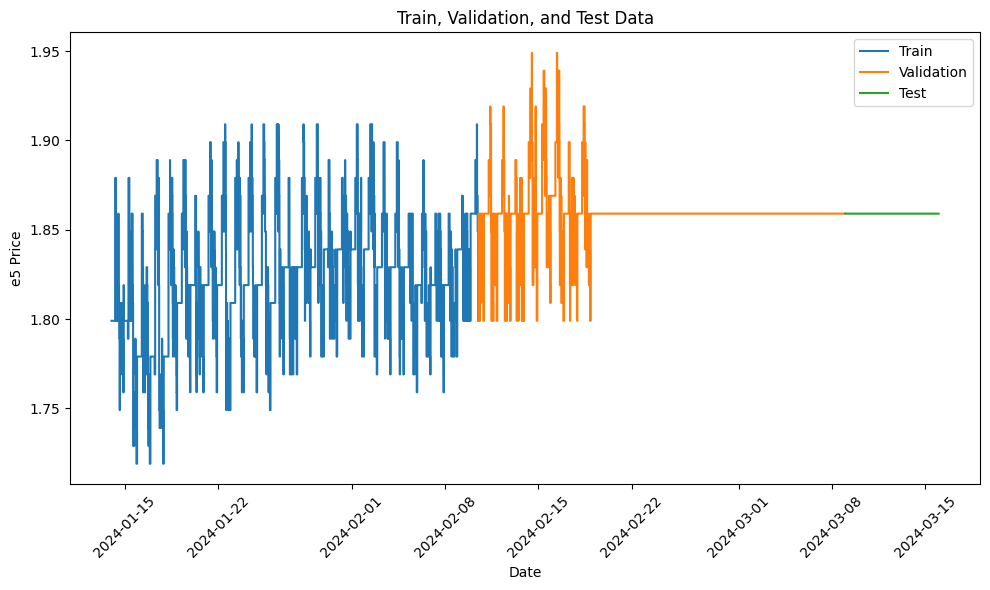

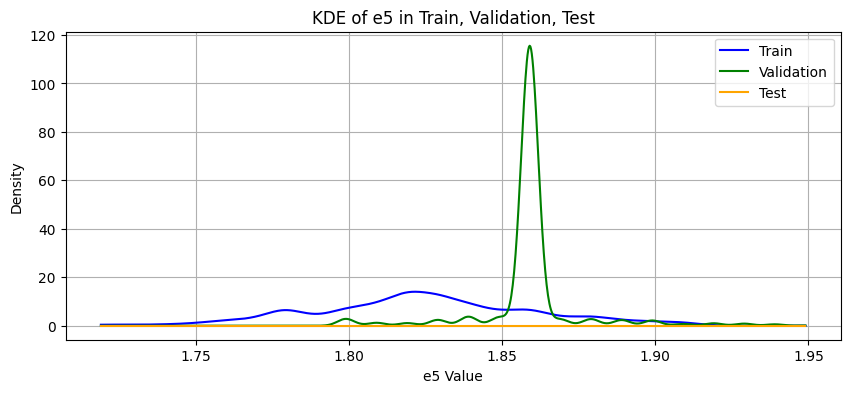

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2024-03-09 00:05:00 to 2024-03-15 00:00:00, to predict 1 day(s)
Test set range: 2024-03-09 00:05:00 to 2024-03-16 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.0675 - val_loss: 0.2419
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 165s 694ms/step - loss: 0.0175 - val_loss: 0.0699
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0057 - val_loss: 0.0069
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0088
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Forecast MSE: 0.0006391668319700727
                     Predicted E5
datetime                         
2024-03-15 00:00:00      1.858361
2024-03-15 00:05:00      1.858361
2024-03-15 00:10:00      1.858361
2024-03-15 00:15:00      1.858361
2024-03-15 00:20:00      1.858361


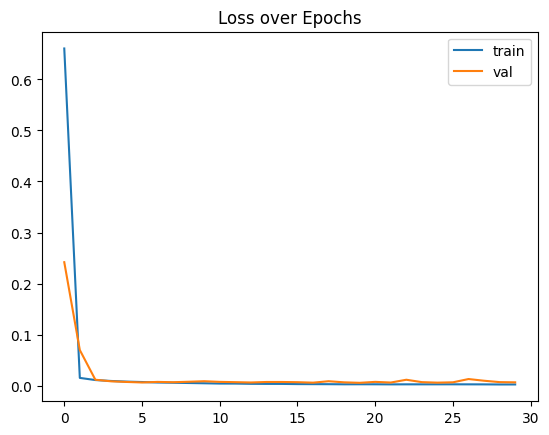

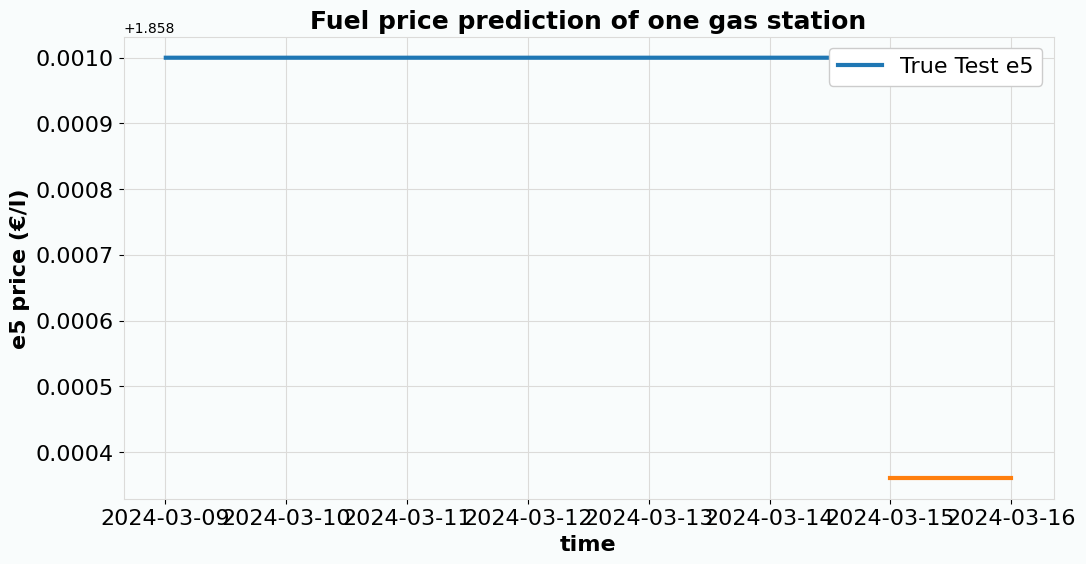

Successfully processed df29

Processing dataset: df30


/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


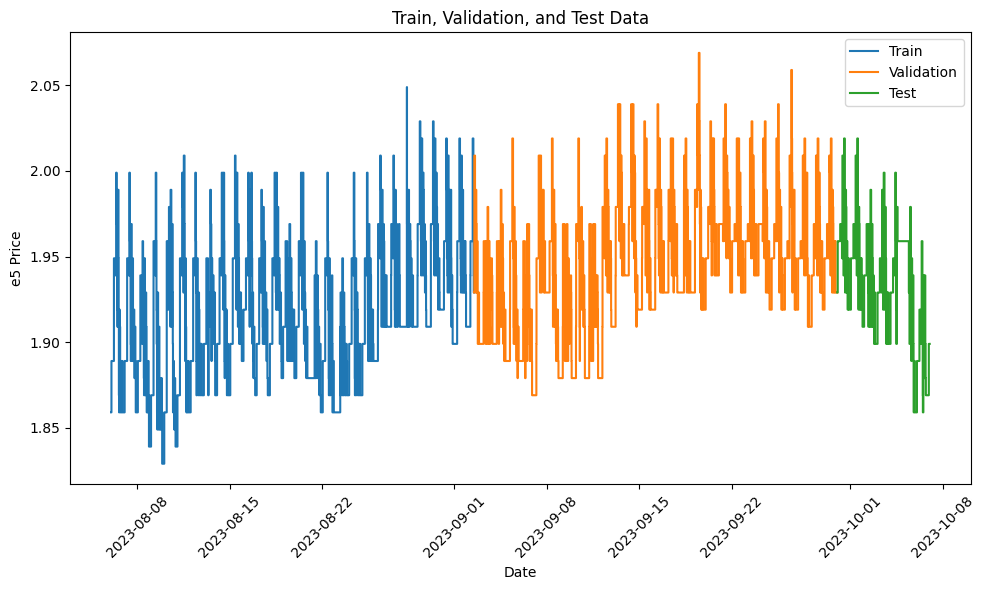

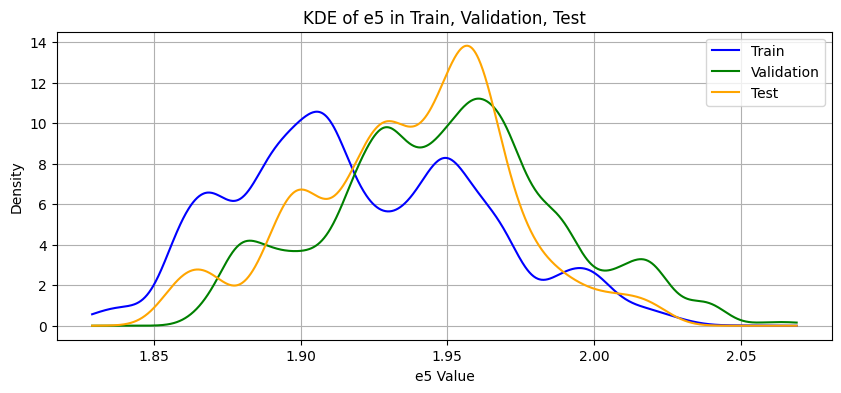

Train shape: (7631, 288, 2)  | Validation shape: (7632, 288, 2)
Forecast setup from 2023-09-30 00:05:00 to 2023-10-06 00:00:00, to predict 1 day(s)
Test set range: 2023-09-30 00:05:00 to 2023-10-07 00:00:00


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.4680 - val_loss: 0.0909
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0131 - val_loss: 0.0281
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - val_loss: 0.0167
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0076 - val_loss: 0.0032
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - val_loss: 0.0091
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Forecast MSE: 0.04979800896719096
                     Predicted E5
datetime                         
2023-10-06 00:00:00      1.916162
2023-10-06 00:05:00      1.914054
2023-10-06 00:10:00      1.914612
2023-10-06 00:15:00      1.914663
2023-10-06 00:20:00      1.914471


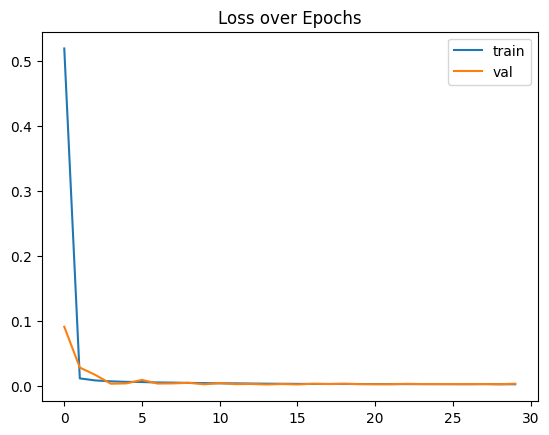

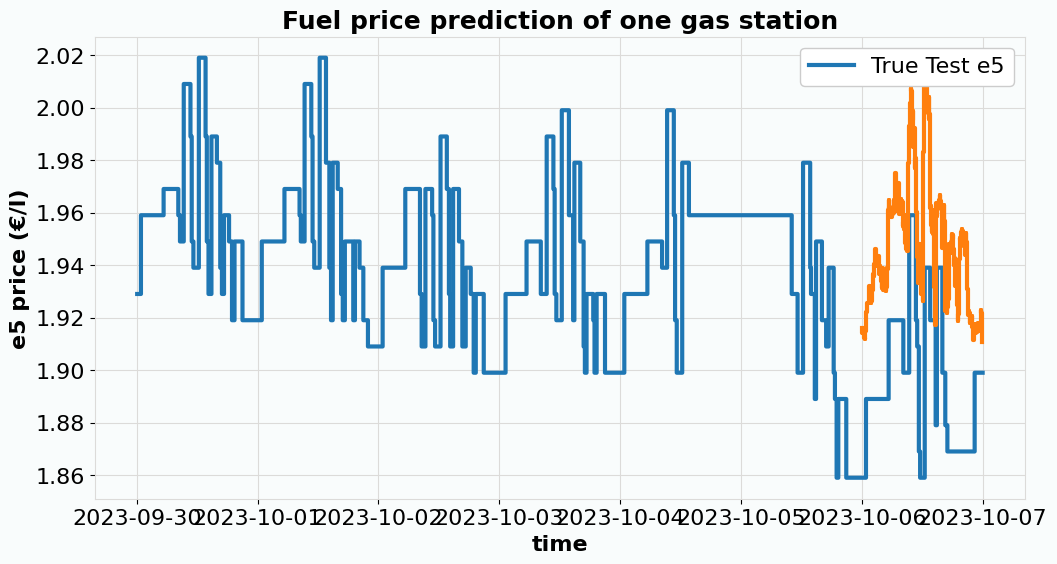

Successfully processed df30

=== Error Summary ===
Total errors: 2

df06:
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


In [18]:
# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_seasonality_{dataset_name}") as run:
            output_days = 1 # default
            fuel='e5' # default

            # PREPROCESSING
            X, y, X_val, y_test, y_val, X_forecast, scaler, scaled_train, val_df, test_df = preprocess(
                    df_train=df_train, 
                    df_test=df_test, 
            )

            # MODELING
            params = {
                'epochs': 30,
                'batch_size': 32,
                'lstm_units': 50
            }

            model_type = 'cnn_big' # choose between: 'ccn_small', 'ccn_big' and 'cnn_lstm_1'
            
            trained_model, history = train_model_with_mlflow(
                X=X, 
                y=y, 
                X_val=X_val, 
                y_val=y_val,
                model_type=model_type,
                params=params
            )

            # FORECASTING
            forecasting(
                X_forecast=X_forecast, 
                scaled_train=scaled_train, 
                scaler=scaler, 
                model=trained_model
            )

        print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)
        
        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

=== Error Summary ===
Total errors: 2

df06:
Error in df06: x must have 2 complete cycles requires 576 observations. x only has 552 observation(s)

df20:
Error in df20: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

# Checking your data with MLFlow:
Start the MLFlow by entering "mlflow ui" into the Terminal and opening the given uri in your browser.
To abort MLflow again, go to terminal and press "ctrl+c".

In [47]:
%mlflow ui --backend-store-uri file:data/mlflow

UsageError: Line magic function `%mlflow` not found.
